# Categorical iffusion model - D3PM

## 0. D3PM paper

In [62]:
# Imports
import math
import os

import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [63]:
# Load data
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## 1. Diffuse image into Categorical Standard Normal noise step by step

Quantization levels K = 16
Absorbing token enabled: False
Vocabulary size: 16
Quantized training samples: 60000
Quantized test samples: 10000


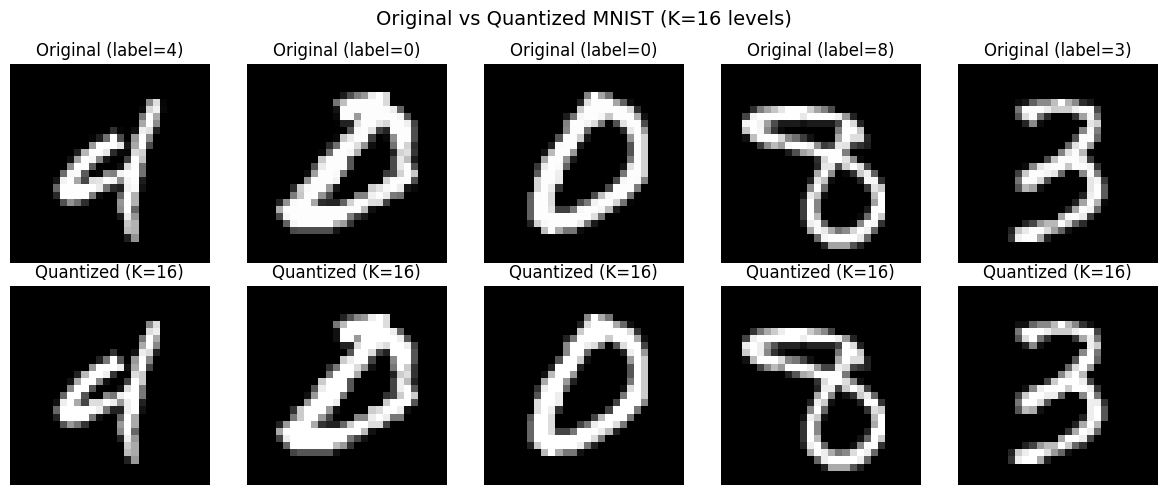

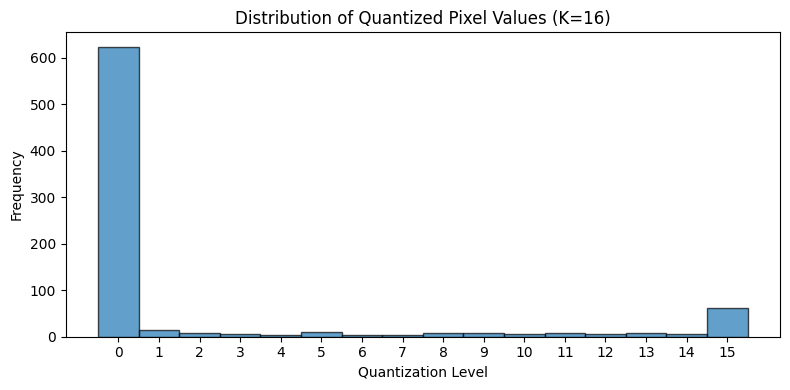

In [64]:
# Create quantized MNIST dataset for D3PM (Discrete Denoising Diffusion Probabilistic Models)

import torch
from torch.utils.data import Dataset, DataLoader

# Number of discrete categories (quantization levels)
K = 16

class QuantizedMNIST(Dataset):
    """
    Quantized MNIST dataset for discrete diffusion models.
    Converts continuous pixel values [0, 1] to discrete categories [0, K-1].
    
    Args:
        base_dataset: Original MNIST dataset
        num_categories: Number of quantization levels (K)
        use_absorbing_token: If True, uses vocabulary of size K+1 where index K is the absorbing state.
                        Data uses [0, K-1] and absorbing state is at index K.
    """
    def __init__(self, base_dataset, num_categories=16, use_absorbing_token=False):
        self.base_dataset = base_dataset
        self.K = num_categories
        self.use_absorbing_token = use_absorbing_token
        # If use_absorbing_token is True, vocabulary size is K+1 (indices 0 to K, where K is absorbing)
        # Data lives in [0, K-1], absorbing state is at index K
        self.vocab_size = num_categories + 1 if use_absorbing_token else num_categories
        # Absorbing state index (only meaningful if use_absorbing_token=True)
        self.absorbing_idx = num_categories if use_absorbing_token else None
    
    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, idx):
        image, label = self.base_dataset[idx]
        
        # Normalize image to [0, 1] range (from [-1, 1] if normalized)
        image_normalized = (image + 1) / 2  # Convert from [-1, 1] to [0, 1]
        image_normalized = torch.clamp(image_normalized, 0, 1)
        
        # Quantize to K discrete levels [0, K-1]
        quantized = (image_normalized * (self.K - 1)).round().long()
        quantized = torch.clamp(quantized, 0, self.K - 1)
        
        return quantized.squeeze(0), label  # Remove channel dim for discrete representation
    
    def get_vocab_size(self):
        """Returns vocabulary size: K if no absorbing token, K+1 if absorbing token enabled."""
        return self.vocab_size

# Create quantized dataset
quantized_train_dataset = QuantizedMNIST(train_dataset, num_categories=K, use_absorbing_token=False)
quantized_test_dataset = QuantizedMNIST(test_dataset, num_categories=K, use_absorbing_token=False)

quantized_train_dataset_absorbing = QuantizedMNIST(train_dataset, num_categories=K, use_absorbing_token=True)
quantized_test_dataset_absorbing = QuantizedMNIST(test_dataset, num_categories=K, use_absorbing_token=True)

print(f"Quantization levels K = {K}")
print(f"Absorbing token enabled: {quantized_train_dataset.use_absorbing_token}")
print(f"Vocabulary size: {quantized_train_dataset.vocab_size}")
print(f"Quantized training samples: {len(quantized_train_dataset)}")
print(f"Quantized test samples: {len(quantized_test_dataset)}")

# Visualize original vs quantized images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))

for i in range(5):
    idx = np.random.randint(len(train_dataset))
    
    # Original image
    orig_image, label = train_dataset[idx]
    axes[0, i].imshow(orig_image.squeeze().cpu(), cmap='gray')
    axes[0, i].set_title(f'Original (label={label})')
    axes[0, i].axis('off')
    
    # Quantized image (convert back to displayable range)
    quant_image, _ = quantized_train_dataset[idx]
    quant_display = quant_image.float() / (K - 1)  # Normalize to [0, 1] for display
    axes[1, i].imshow(quant_display.cpu(), cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Quantized (K={K})')
    axes[1, i].axis('off')

plt.suptitle(f'Original vs Quantized MNIST (K={K} levels)', fontsize=14)
plt.tight_layout()
plt.show()

# Show histogram of quantized values
sample_quant, _ = quantized_train_dataset[0]
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(sample_quant.flatten().numpy(), bins=K, range=(-0.5, K-0.5), edgecolor='black', alpha=0.7)
ax.set_xlabel('Quantization Level')
ax.set_ylabel('Frequency')
ax.set_title(f'Distribution of Quantized Pixel Values (K={K})')
ax.set_xticks(range(K))
plt.tight_layout()
plt.show()

 Image $x$ and Noise $\varepsilon$ are Categorical Random Variables (RVs).
 
 Diffused image RV $x_t$ = image RV $x_{t-1}$ + noise RV $\varepsilon$.

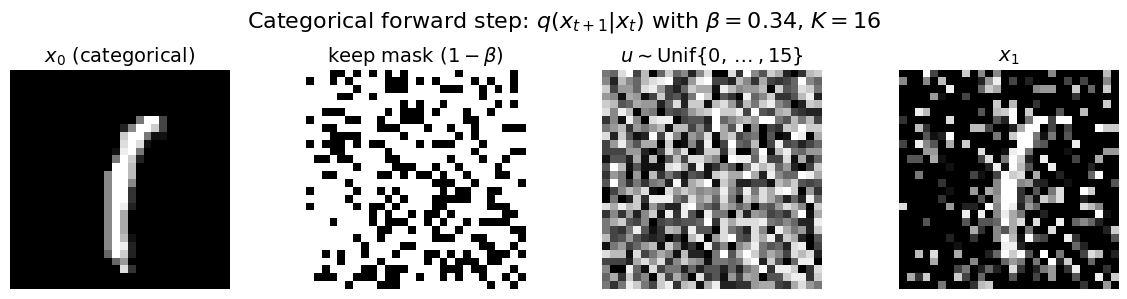

In [65]:
# categorical forward diffusion step (D3PM-style)

FONTSIZE = 14

beta = float(np.random.uniform(0.1, 0.5))

sample_idx = np.random.randint(len(quantized_train_dataset))
x0, sample_label = quantized_train_dataset[sample_idx]  # {0,...,K-1}, [H,W]

K = int(quantized_train_dataset.K)

# q(x_{t+1}=j | x_t=i) = (1-β) 1[j=i] + β/K
keep_probability = 1 - beta
keep = torch.rand_like(x0.float()) < keep_probability
u = torch.randint(0, K, x0.shape, device=x0.device)
x1 = torch.where(keep, x0, u)

# visualize back in [0,1]
x0_vis = x0.float() / (K - 1)
u_vis = u.float() / (K - 1)
x1_vis = x1.float() / (K - 1)
keep_vis = keep.float()

fig, axes = plt.subplots(1, 4, figsize=(12, 3))
for ax in axes.ravel():
    ax.axis("off")

axes[0].imshow(x0_vis.cpu(), cmap="gray", vmin=0, vmax=1)
axes[0].set_title(r"$x_0$ (categorical)", fontsize=FONTSIZE)

axes[1].imshow(keep_vis.cpu(), cmap="gray", vmin=0, vmax=1)
axes[1].set_title(r"keep mask ($1-\beta$)", fontsize=FONTSIZE)

axes[2].imshow(u_vis.cpu(), cmap="gray", vmin=0, vmax=1)
axes[2].set_title(rf"$u \sim \mathrm{{Unif}}\{{0,\dots,{K-1}\}}$", fontsize=FONTSIZE)

axes[3].imshow(x1_vis.cpu(), cmap="gray", vmin=0, vmax=1)
axes[3].set_title(r"$x_1$", fontsize=FONTSIZE)

fig.suptitle(rf"Categorical forward step: $q(x_{{t+1}}|x_t)$ with $\beta={beta:.2f}$, $K={K}$", fontsize=16)
plt.tight_layout()
plt.show()

#### Transition kernels

Forward transition kernel $ Q $ for any site $n$ is a matrix of shape $K \times K$ with transition probs (shared across sites):

$$
Q_t[k,j] = Pr(x_t^{(n)} = j | x_{t-1}^{(n)} = k), \space\space\space\space
\sum_{j=1}^K Q_t [k,j] = 1 \space\space\space\space
\forall n \in \{1, ..., N\}
$$

The joint transition kernel updates each site independently:

$$ q(x_t | x_{t-1}) = \prod_{n=1}^N Q_t[x_{t-1}^{(n)}, x_t^{(n)}]$$

#### Possible Transition kernels

 **Uniform transition kernel**
$$ Q_t = (1-\beta_t)\mathbf{I} + \beta_t \cdot \frac{1}{K} \mathbf{1} \mathbf{1}^T$$

 **Discrete Gaussian transition kernel (only for ordered tokens)**:

 Unnormalized:
 $$ \tilde{Q}_t[k,j] = (1-\beta_t) \mathbf{1}[j=k] + \beta_t \cdot \exp\left(-\frac{(j-k)^2}{2\sigma^2}\right) $$
 Normalized:
 $$ Q_t[k,j] = \frac{\tilde{Q}_t[k,j]}{\sum_{j'=0}^{K-1} \tilde{Q}_t[k,j']} $$
 
 **Absorbing transition kernel**:

For $k \neq MASK$:
 $$ Q_t[k,j] = (1-\beta_t) \mathbf{1}[j=k] + \beta_t \cdot \mathbf{1}[j=\text{MASK}] $$

For $k = MASK$:
$$ Q_t[MASK, j] = 1[j=MASK]

/tmp/ipython-input-7292/796967635.py:155: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  gray_cmap = cm.get_cmap('gray', V_abs)


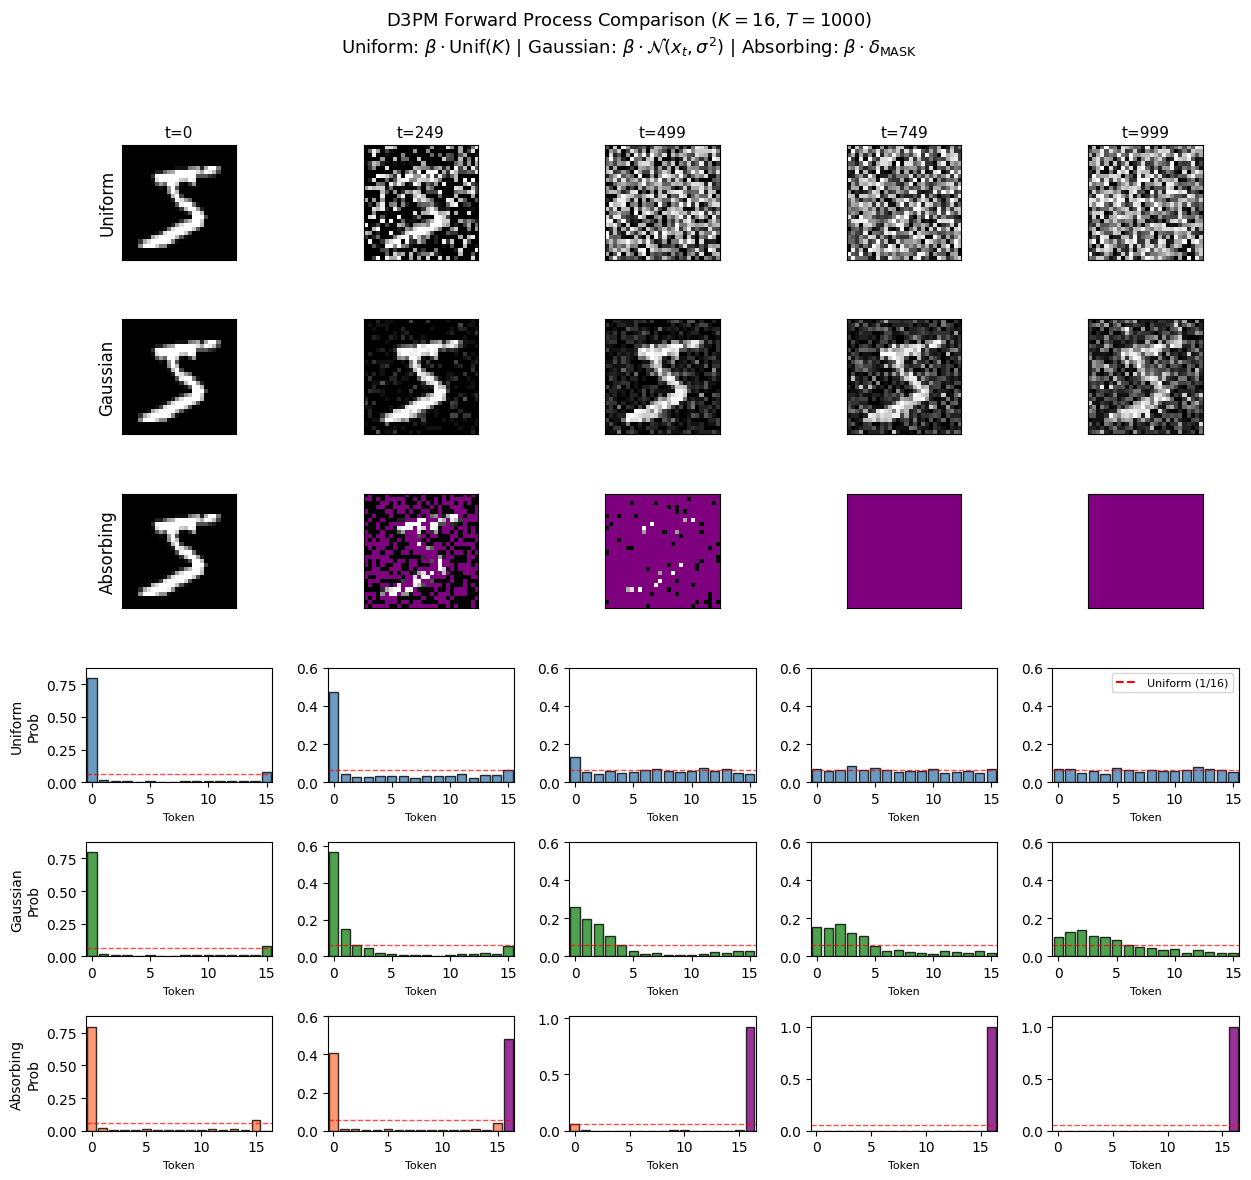

In [66]:
# visualize discrete D3PM forward process: Uniform vs Gaussian vs Absorbing

import numpy as np
import torch
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

T = 1000
beta_start, beta_end = 1e-4, 2e-2
betas = torch.linspace(beta_start, beta_end, T, device=device)  # [T]

num_steps = 5
# pick 5 timesteps including 0 and T-1, evenly spaced
timesteps = np.linspace(0, T-1, num_steps, dtype=int).tolist()

torch.manual_seed(0)
np.random.seed(0)

# ----------------------------
# Pick one image (quantized) - use regular for uniform/gaussian, absorbing for absorbing
# ----------------------------
x0, _ = quantized_train_dataset[0]  # {0,...,K-1}, [H,W]
x0 = x0.to(device)
K = int(quantized_train_dataset.K)

# Get absorbing sample (data tokens still in {0,...,K-1})
x0_absorbing, _ = quantized_train_dataset_absorbing[0]  # [H,W]
x0_absorbing = x0_absorbing.to(device)

# Data K (0..K-1), absorbing vocab size V=K+1 (0..K, where K is MASK)
K = int(quantized_train_dataset.K)
V_abs = int(quantized_train_dataset_absorbing.get_vocab_size())  # == K+1
ABSORB_TOKEN = int(quantized_train_dataset_absorbing.absorbing_idx)  # == K

assert V_abs == K + 1
assert ABSORB_TOKEN == K

# ----------------------------
# Run three D3PM forward processes step-by-step
# 1. Uniform: q(x_{t+1}=j | x_t=i) = (1-β) 1[j=i] + β/K
# 2. Gaussian: q(x_{t+1}=j | x_t=i) = (1-β) 1[j=i] + β * N(j; i, σ²) (discretized)
# 3. Absorbing: q(x_{t+1}=j | x_t=i) = (1-β) 1[j=i] + β * 1[j=MASK]
# ----------------------------

def run_uniform_process(x0, betas, K, timesteps):
    """Uniform transition: jump to any token with equal probability"""
    x_t = x0.clone()
    snapshots = {0: x_t.detach().cpu()}
    
    for t in range(1, T):
        beta = betas[t].item()
        keep_prob = 1 - beta
        keep = torch.rand_like(x_t.float()) < keep_prob
        u = torch.randint(0, K, x_t.shape, device=device)
        x_t = torch.where(keep, x_t, u)
        
        if t in timesteps:
            snapshots[t] = x_t.detach().cpu()
    
    return [snapshots[t] for t in timesteps]

def run_gaussian_process(x0, betas, K, timesteps, sigma_schedule=None, device=None):
    """
    Categorical-Gaussian transition:
      q(x_{t+1}=j | x_t=i) = (1-beta_t) * 1[j=i] + beta_t * G_{sigma_t}(j|i)
    where
      G_{sigma}(j|i) ∝ exp(-(j-i)^2 / (2*sigma^2))  over j in {0,...,K-1} (row-normalized).
    """
    assert x0.dtype == torch.long
    if device is None:
        device = x0.device

    T = int(betas.shape[0])
    if sigma_schedule is None:
        sigma_schedule = lambda t: 1.5  # constant sigma

    x_t = x0.to(device).clone()  # [H,W] long
    snapshots = {0: x_t.detach().cpu()}

    for t in range(1, T):
        beta_t = betas[t].to(device)  # scalar tensor
        keep = (torch.rand_like(x_t.float()) < (1.0 - beta_t))

        sigma_t = float(sigma_schedule(t))
        sigma2 = sigma_t * sigma_t + 1e-12

        # Build G_sigma as [K,K]: rows i, cols j
        i = torch.arange(K, device=device).view(K, 1)
        j = torch.arange(K, device=device).view(1, K)
        dist2 = (j - i).float().pow(2)
        logp = -0.5 * dist2 / sigma2
        G = torch.softmax(logp, dim=1)  # [K,K], each row sums to 1

        # Sample u per pixel: u ~ Categorical(G[x_t[p], :])
        x_flat = x_t.view(-1)                    # [N]
        probs = G.index_select(0, x_flat)        # [N,K]
        u_flat = torch.multinomial(probs, 1).squeeze(1).long()  # [N]
        u = u_flat.view_as(x_t)                  # [H,W]

        x_t = torch.where(keep, x_t, u)

        if t in timesteps:
            snapshots[t] = x_t.detach().cpu()

    return [snapshots[t] for t in timesteps]

def run_absorbing_process(x0, betas, K, timesteps, absorb_token):
    """Absorbing transition: jump to a single absorbing/mask token"""
    x_t = x0.clone()
    snapshots = {0: x_t.detach().cpu()}
    
    for t in range(1, T):
        beta = betas[t].item()
        keep_prob = 1 - beta
        keep = torch.rand_like(x_t.float()) < keep_prob
        mask_tensor = torch.full_like(x_t, absorb_token)
        x_t = torch.where(keep, x_t, mask_tensor)
        
        if t in timesteps:
            snapshots[t] = x_t.detach().cpu()
    
    return [snapshots[t] for t in timesteps]

# Run all three processes
torch.manual_seed(0)
snapshots_uniform = run_uniform_process(x0, betas, K, timesteps)

torch.manual_seed(0)
snapshots_gaussian = run_gaussian_process(x0, betas, K, timesteps)

torch.manual_seed(0)
snapshots_absorbing = run_absorbing_process(x0_absorbing, betas, V_abs, timesteps, ABSORB_TOKEN)

# ----------------------------
# Plot: 3 rows (processes) × num_steps cols (timesteps)
# Plus 3 more rows for token distributions
# ----------------------------
fig, axes = plt.subplots(6, num_steps, figsize=(2.5*num_steps, 12))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

process_names = ["Uniform", "Gaussian", "Absorbing"]
all_snapshots = [snapshots_uniform, snapshots_gaussian, snapshots_absorbing]
all_K = [K, K, V_abs]
colors = ['steelblue', 'forestgreen', 'coral']

# Create a custom colormap for absorbing process (purple for absorbing token)
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm

# Create purple colormap for absorbing: grayscale for tokens 0 to K-1, purple for MASK token (K)
gray_cmap = cm.get_cmap('gray', V_abs)
absorbing_colors = [gray_cmap(i / (K - 1)) for i in range(K)]  # K data tokens (0 to K-1)
absorbing_colors.append((0.5, 0.0, 0.5, 1.0))  # Purple for absorbing token (index K)
absorbing_cmap = ListedColormap(absorbing_colors)

for row_idx, (name, snapshots, num_tokens, color) in enumerate(zip(process_names, all_snapshots, all_K, colors)):
    for j, t in enumerate(timesteps):
        x_img = snapshots[j]  # [H,W], values in {0,...,K-1}
        
        # --- image row ---
        ax = axes[row_idx, j]
        if name == "Absorbing":
            # Use custom colormap with purple for absorbing token
            ax.imshow(x_img, cmap=absorbing_cmap, vmin=0, vmax=num_tokens-1)
        else:
            x_vis = x_img.float() / (num_tokens - 1)
            ax.imshow(x_vis, cmap="gray", vmin=0, vmax=1)
        if row_idx == 0:
            ax.set_title(f"t={t}", fontsize=11)
        ax.set_xticks([]); ax.set_yticks([])
        if j == 0:
            ax.set_ylabel(name, fontsize=12)

        # --- token distribution row ---
        ax2 = axes[row_idx + 3, j]
        token_counts = torch.bincount(x_img.flatten(), minlength=num_tokens).numpy()
        token_probs = token_counts / token_counts.sum()
        
        # For absorbing process, color the absorbing token bar purple
        if name == "Absorbing":
            bar_colors = [color] * (num_tokens - 1) + ['purple']
            ax2.bar(range(num_tokens), token_probs, color=bar_colors, edgecolor='black', alpha=0.8)
        else:
            ax2.bar(range(num_tokens), token_probs, color=color, edgecolor='black', alpha=0.8)
        ax2.axhline(y=1/num_tokens, color='red', linestyle='--', linewidth=1.0, alpha=0.7)
        ax2.set_xlim(-0.5, num_tokens-0.5)
        ax2.set_ylim(0, max(0.6, token_probs.max() * 1.1))
        ax2.set_xlabel("Token", fontsize=8)
        if j == 0:
            ax2.set_ylabel(f"{name}\nProb", fontsize=10)

# Adjust vertical spacing: smaller gap for image rows (0-2), normal for distribution rows (3-5)
for row_idx in range(3):
    for ax in axes[row_idx]:
        pos = ax.get_position()
        ax.set_position([pos.x0, pos.y0 + 0.05, pos.width, pos.height])

# Add legend for uniform reference line
axes[3, -1].plot([], [], 'r--', label=f'Uniform (1/{K})')
axes[3, -1].legend(fontsize=8, loc='upper right')

fig.suptitle(f"D3PM Forward Process Comparison ($K={K}$, $T={T}$)\n"
             f"Uniform: $\\beta \\cdot \\mathrm{{Unif}}(K)$ | "
             f"Gaussian: $\\beta \\cdot \\mathcal{{N}}(x_t, \\sigma^2)$ | "
             f"Absorbing: $\\beta \\cdot \\delta_{{\\mathrm{{MASK}}}}$", fontsize=13)
plt.tight_layout()
plt.show()

## 2. The Markov chain

### **2.1 Markov property for diffusion process**

**Markov property (diffusion)**:
Current noised image $x_t$ depends only on previous step $x_{t-1}$

 ![Markov Forward Process](static/markov_forward.png)

Why? It enables us to sample diffused images efficiently! (helpful for training)

### **2.1 Markov property for denoising process**

**Markov property (denosing)**:
Previous noised image $x_{t-1}$ depends only on current step $x_{t}$

  ![Markov Backward Process](static/markov_backward.png)

Can we also sample denoised images efficiently? (during inference)

Yes, but not as trivially as for diffusion.

## 3. How to denoise?

**Question 1**: Why cant we just compute the previous step $x_{t-1}$ given known $x_t$?

<img src="static/diffusion_vs_denoising_per_step.png" width="800">

**Answer to both Q1, Q2**: At inference time the noise $\varepsilon$ is **unknown**

<img src="static/diffustion_vs_denoising_aggregated.png" width="800">

**Question 2**: So, how do we generate images $\hat{x}_0$ from noise?

**Answer to Q2**: We train a model to predict the noise itself instead of denoised images!

   <img src="static/ddpm_train.png" width="800">

**Question 3**: How to sample from a trained model?

 **Answer to Q3**: We run an iterative denoising procedure

For all $t \in \{0, \ldots, N-1\}$:
1. Predict the initial distribution $\pi_i$ for every $i=1...K$
2. Compute the conditional posterior $ q(x_{t-1}=k | x_t = j, x_0 = i)$ for every $i=1...K$
3. Compute the full posterior $ p_\theta(x_{t-1} = k | x_t = j) $ by law of total probability
4. Sample $ x_{t-1} $ from the full posterior $ p_\theta(x_{t-1} = k | x_t = j) $

### 3.1 Sampling (inference)

1. Predict the initial distribution $\pi_i$ for every $i=1...K$

 $$ \pi^{(n)}_i= p_\theta(x_0^{(n)}=i | x_t, \space t) \space\space\space\space \forall i=1...K $$

2. Compute the conditional posterior $ q(x_{t-1}=k | x_t = j, x_0 = i)$ for every $i=1...K$

$$ q (x_{t-1} = k | x_t=j, x_0=i) = $$
$$ = \frac{q (x_t=j | x_{t-1}=k, x_0=i)\cdot q (x_{t-1}=k | x_0=i)}{q (x_t=j | x_0=i)} = $$
$$ = \frac{Q_t[k,j] \bar{Q}_{t-1}[i,k]}{\bar{Q_t}[i,j]} $$

3. Compute the full posterior $ p_\theta(x_{t-1} = k | x_t = j) $ by law of total probability:
$$ p_\theta (x_{t-1}|x_t=j) = \sum_{i=1}^K \pi_i \space q (x_{t-1}=k | x_t=j, x_0=i) $$

4. Sample $ x_{t-1} $ from the full posterior $ p_\theta(x_{t-1} = k | x_t = j) $:
$$ x_{t-1} \sim p_\theta(x_{t-1} = j | x_t = k, t)  $$

## 4. Let's train a model!

In [67]:
# set device

def get_device():
    if torch.cuda.is_available():
        return "cuda"
    elif torch.backends.mps.is_available():
        return "mps"
    return "cpu"

device = get_device()
print(f"Using device: {device}")

Using device: cuda


### 4.0 Beta schedules

 **Linear schedule:**
 
 $$ \bar{\alpha}_t = 1 - (1 - \varepsilon) \frac{t}{T} $$
 
 Then compute $\beta_t$ via the ratio formula:
 
 $$ \beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}} $$
 
 This gives a gentle, steady decay.
 
 ---
 

In [68]:
def linear_schedule(T, eps=1e-4):
    """
    Linear schedule for diffusion.
    
    Computes:
        alpha_bar_t = 1 - (1 - eps) * t / T
        beta_t = 1 - alpha_bar_t / alpha_bar_{t-1}
    
    Args:
        T: number of timesteps
        eps: small constant to prevent alpha_bar from reaching 0
    
    Returns:
        betas: tensor of shape (T,) with beta values
        alpha_bars: tensor of shape (T,) with cumulative alpha values
    """
    # TODO: Create timestep indices from 0 to T-1
    t = np.arange(0, T)
    
    # TODO: Compute alpha_bar_t = 1 - (1 - eps) * t / T
    alpha_bar_t = 1 - (1-eps) * t / T
    
    # TODO: Compute beta_t = 1 - alpha_bar_t / alpha_bar_{t-1}
    # Hint: Handle t=0 case separately (beta_0 = 1 - alpha_bar_0)
    alpha_bar_t_prev = np.roll(alpha_bar_t, 1)
    beta_t = 1 - alpha_bar_t / alpha_bar_t_prev
    beta_t[0] = 1 - alpha_bar_t[0]
    
    # TODO: Clamp betas to valid range [0, 1)
    beta_t = np.clip(beta_t, 0, 1)

    # Compute alpha_t = 1 - beta_t
    alpha_t = 1 - beta_t
    
    # TODO: Return betas, alphas, and alpha_bars
    return beta_t, alpha_t, alpha_bar_t

 **Cosine schedule (often nicer):**
 
 Cosine-style keep mass:
 
 $$ \bar{\alpha}_t = \varepsilon + (1 - \varepsilon) \cos^2 \left( \frac{\pi}{2} \frac{t}{T} \right) $$
 
 Then again:
 
 $$ \beta_t = 1 - \frac{\bar{\alpha}_t}{\bar{\alpha}_{t-1}} $$

 ---

In [69]:
def cosine_schedule(T, eps=1e-4):
    """
    Cosine noise schedule for diffusion models.
    
    Computes:
        alpha_bar_t = eps + (1 - eps) * cos^2(pi/2 * t/T)
        beta_t = 1 - alpha_bar_t / alpha_bar_{t-1}
        alpha_t = 1 - beta_t
    
    Args:
        T: number of timesteps
        eps: small constant to prevent alpha_bar from reaching 0
    
    Returns:
        betas: tensor of shape (T,) with beta values
        alphas: tensor of shape (T,) with alpha values
        alpha_bars: tensor of shape (T,) with cumulative alpha values
    """
    # TODO: Create timestep indices from 0 to T-1
    t = np.arange(0, T)
    
    # TODO: Compute alpha_bar_t = eps + (1 - eps) * cos^2(pi/2 * t/T)
    alpha_bar_t = eps + (1 - eps) * np.cos(np.pi / 2 * t / T) ** 2
    
    # TODO: Compute beta_t = 1 - alpha_bar_t / alpha_bar_{t-1}
    # Hint: Handle t=0 case separately (beta_0 = 1 - alpha_bar_0)
    alpha_bar_t_prev = np.roll(alpha_bar_t, 1)
    beta_t = 1 - alpha_bar_t / alpha_bar_t_prev
    beta_t[0] = 1 - alpha_bar_t[0]
    
    # TODO: Clamp betas to valid range [0, 1)
    beta_t = np.clip(beta_t, 0, 1)
    
    # Compute alpha_t = 1 - beta_t
    alpha_t = 1 - beta_t
    
    # TODO: Return betas, alphas, and alpha_bars
    return beta_t, alpha_t, alpha_bar_t

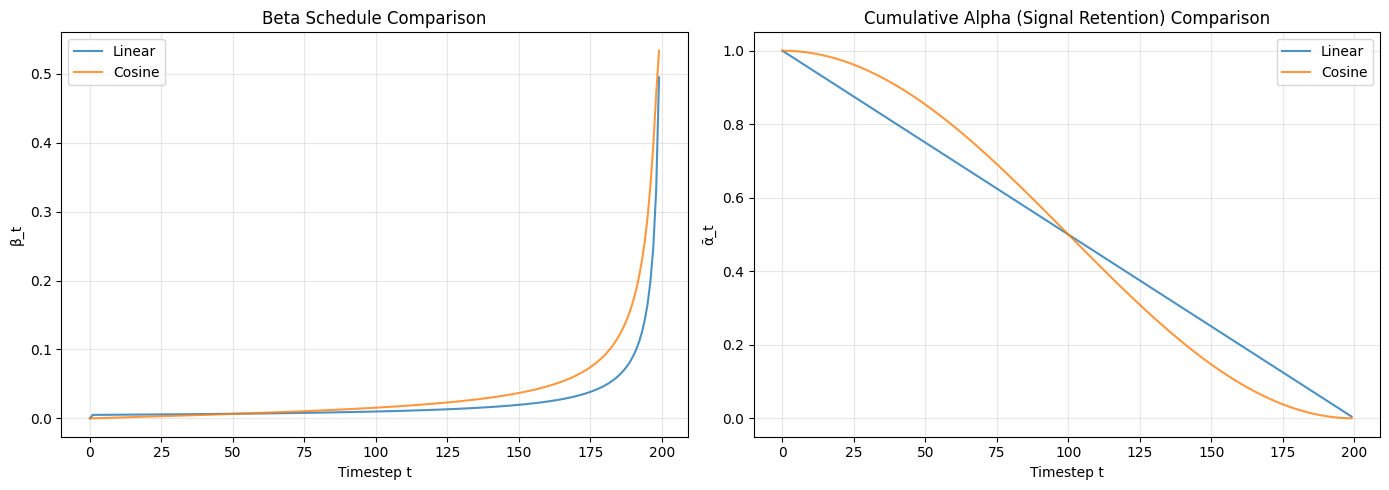

Linear schedule:
  β range: [0.000000, 0.495049]
  ᾱ range: [0.005100, 1.000000]

Cosine schedule:
  β range: [0.000000, 0.533661]
  ᾱ range: [0.000162, 1.000000]


In [70]:
# Compare linear vs cosine schedules
T = 200

# Get both schedules (linear_schedule returns 3 values, cosine_schedule returns 3 values)
linear_betas, linear_alphas, linear_alpha_bars = linear_schedule(T)
cosine_betas, cosine_alphas, cosine_alpha_bars = cosine_schedule(T)

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot betas
axes[0].plot(linear_betas, label='Linear', alpha=0.8)
axes[0].plot(cosine_betas, label='Cosine', alpha=0.8)
axes[0].set_xlabel('Timestep t')
axes[0].set_ylabel('β_t')
axes[0].set_title('Beta Schedule Comparison')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot alpha_bars (cumulative noise)
axes[1].plot(linear_alpha_bars, label='Linear', alpha=0.8)
axes[1].plot(cosine_alpha_bars, label='Cosine', alpha=0.8)
axes[1].set_xlabel('Timestep t')
axes[1].set_ylabel('ᾱ_t')
axes[1].set_title('Cumulative Alpha (Signal Retention) Comparison')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print key statistics
print("Linear schedule:")
print(f"  β range: [{linear_betas.min():.6f}, {linear_betas.max():.6f}]")
print(f"  ᾱ range: [{linear_alpha_bars.min():.6f}, {linear_alpha_bars.max():.6f}]")
print(f"\nCosine schedule:")
print(f"  β range: [{cosine_betas.min():.6f}, {cosine_betas.max():.6f}]")
print(f"  ᾱ range: [{cosine_alpha_bars.min():.6f}, {cosine_alpha_bars.max():.6f}]")

### 4.1 Transition kernels

Forward transition kernel $ Q $ for any site $n$ is a matrix of shape $K \times K$ with transition probs (shared across sites):

$$
Q_t[k,j] = Pr(x_t^{(n)} = j | x_{t-1}^{(n)} = k), \space\space\space\space
\sum_{j=1}^K Q_t [k,j] = 1 \space\space\space\space
\forall n \in \{1, ..., N\}
$$

The joint transition kernel updates each site independently:

$$ q(x_t | x_{t-1}) = \prod_{n=1}^N Q_t[x_{t-1}^{(n)}, x_t^{(n)}]$$

 Transition kernel $Q_t$ converges to a stationary distribution $\pi$, where $\pi Q_t = \pi$.

 ---

 **Uniform transition kernel**
$$ Q_t = (1-\beta_t)\mathbf{I} + \beta_t \cdot \frac{1}{K} \mathbf{1} \mathbf{1}^T$$

*Stationary distribution:*
$$ \pi = \frac{1}{K} \mathbf{1} $$


In [71]:
def uniform_kernel(beta_t, K):
    """Uniform transition: stay with prob (1-β), else jump uniformly."""
    beta_t = float(beta_t)
    I = np.eye(K, dtype=np.float64)
    uniform_matrix = np.full((K, K), 1.0 / K, dtype=np.float64)
    Q_t = (1.0 - beta_t) * I + beta_t * uniform_matrix
    pi = np.full((K,), 1.0 / K, dtype=np.float64)
    return Q_t, pi

--- 

 **Discrete Gaussian transition kernel (only for ordered tokens)**:

 *Unnormalized kernel*:
 $$ \tilde{Q}_t[k,j] = (1-\beta_t) \mathbf{1}[j=k] + \beta_t \cdot \exp\left(-\frac{(j-k)^2}{2\sigma^2}\right) $$
 *Normalized kernel*:
 $$ Q_t[k,j] = \frac{\tilde{Q}_t[k,j]}{\sum_{j'=0}^{K-1} \tilde{Q}_t[k,j']} $$

 *Stationary distribution*:

Given 
$$s_k = \sum_{j=0}^{K-1} \tilde{Q}_t[k,j] = (1-\beta_t) + \beta_t \sum_{j=0}^{K-1} \exp\left(-\frac{(j-k)^2}{2\sigma^2}\right)$$

we have:
$$ \pi_k = \frac{s_k}{\sum_{u=0}^{K-1} s_u} \quad (\text{i.e. } \pi \propto s). $$

In [72]:
def gaussian_kernel(beta_t, K, sigma=1.0):
    """
    Compute the discrete Gaussian transition kernel for D3PM.

    The Gaussian kernel is suitable for ordered tokens (like pixel intensities)
    where nearby values should have higher transition probabilities.

    Formula (unnormalized):
        Q_tilde[k,j] = (1 - beta_t) * 1[j=k] + beta_t * exp(-(j-k)^2 / (2*sigma^2))

    Then normalize each row to sum to 1.

    Args:
        beta_t: Noise level at timestep t (scalar, 0 < beta_t < 1)
        K: Number of discrete states/tokens (vocabulary size)
        sigma: Standard deviation of the Gaussian (controls spread of transitions)

    Returns:
        Q_t: Transition matrix of shape [K, K] where Q_t[k, j] = P(x_t = j | x_{t-1} = k)
              Each row sums to 1.
        pi: Stationary distribution of shape [K] where pi[k] = P_pi(x=k) and pi @ Q_t = pi
    """
    # Create indices for computing distances
    k = np.arange(K).reshape(-1, 1)  # [K, 1] - source states
    j = np.arange(K).reshape(1, -1)  # [1, K] - target states

    # TODO: Compute Gaussian weights: exp(-(j-k)^2 / (2*sigma^2))
    gaussian_weights = np.exp(-((j - k) ** 2) / (2 * sigma ** 2))

    # Create identity matrix for the "stay in place" component
    I = np.eye(K)

    # TODO: Compute unnormalized transition matrix
    # Q_tilde[k,j] = (1 - beta_t) * 1[j=k] + beta_t * gaussian_weights[k,j]
    Q_tilde = (1 - beta_t) * I + beta_t * gaussian_weights

    # TODO: Normalize each row to sum to 1
    row_sums = Q_tilde.sum(axis=1, keepdims=True)
    Q_t = Q_tilde / row_sums

    # TODO: Compute stationary distribution pi[k] ∝ sum_j Q_tilde[k, j]
    s = row_sums.squeeze(-1)
    pi = s / s.sum()

    # TODO: Return the transition matrix Q_t and stationary distribution pi
    return Q_t, pi

 ---

 **Absorbing transition kernel**:

 For $k \neq MASK$:
 $$ Q_t[k,j] = (1-\beta_t) \mathbf{1}[j=k] + \beta_t \cdot \mathbf{1}[j=\text{MASK}] $$

 For $k = MASK$:
 $$ Q_t[MASK, j] = 1[j=MASK] $$

 *Stationary distribution:*
  $$ \pi = \delta_{MASK} \quad (\pi_{MASK}=1,\; \pi_k=0\;\text{for } k\neq MASK). $$
 
  > **Note:** $\delta_{MASK}$ is the **Dirac delta distribution** centered at the MASK token—a "one-hot" vector where all probability mass is on the MASK state. This makes sense because the absorbing kernel always transitions tokens toward MASK and never leaves MASK once reached, so at equilibrium, everything ends up in the MASK state.


In [73]:
def absorbing_kernel(beta_t, K, mask_token=None):
    """
    Compute the absorbing transition matrix Q_t for D3PM.

    The absorbing kernel transitions tokens to a special MASK token with probability beta_t,
    and stays in place with probability (1 - beta_t). Once in the MASK state, it stays there.

    For k != MASK:
        Q_t[k, j] = (1 - beta_t) * 1[j=k] + beta_t * 1[j=MASK]

    For k = MASK:
        Q_t[MASK, j] = 1[j=MASK]

    Args:
        beta_t: Noise level at timestep t (scalar, 0 < beta_t < 1)
        K: Number of discrete states/tokens (vocabulary size, including MASK token)
        mask_token: Index of the MASK token (default: K-1, the last token)

    Returns:
        Q_t: Transition matrix of shape [K, K] where Q_t[k, j] = P(x_t = j | x_{t-1} = k)
              Each row sums to 1.
        pi: Stationary distribution of shape [K] (delta at MASK)
    """
    # Set default mask_token to K-1 if not provided
    if mask_token is None:
        mask_token = K - 1

    # TODO: Initialize Q_t as zeros matrix of shape [K, K]
    Q_t = np.zeros((K, K), dtype=np.float64)

    # TODO: For non-MASK tokens (k != MASK):
    # - Stay in place with probability (1 - beta_t): Q_t[k, k] = (1 - beta_t)
    # - Transition to MASK with probability beta_t: Q_t[k, MASK] = beta_t
    idx = np.arange(K)
    non_mask = idx != mask_token
    Q_t[non_mask, idx[non_mask]] = 1.0 - beta_t
    Q_t[non_mask, mask_token] = beta_t

    # TODO: For MASK token: stays in MASK state with probability 1
    Q_t[mask_token, mask_token] = 1.0

    # TODO: Create stationary distribution pi = delta_{MASK}
    pi = np.zeros(K, dtype=np.float64)
    pi[mask_token] = 1.0

    # TODO: Return the transition matrix Q_t and stationary distribution pi
    return Q_t, pi

### 4.2 Train loop

  **Training Steps for D3PM:**
  1. Sample a batch of clean data $x_0$ from the dataset
  2. Sample random timesteps $t \sim \text{Uniform}(1, T)$ for each sample in the batch
  3. Corrupt $x_0$ to $x_t$ using the cumulative transition matrix $\bar{Q}_t$: $p(x_t | x_0) = x_0 \cdot \bar{Q}_t$
  4. Pass $x_t$ and $t$ to the model to predict $p(x_0 | x_t)$
  5. Compute cross-entropy loss between predicted $x_0$ distribution and true $x_0$
  6. Backpropagate and update model parameters

In [74]:
def train_step(model, x_0, optimizer, time_steps, Q, Q_bar, device):
    """
    Single training step for D3PM (Discrete Denoising Diffusion Probabilistic Model).

    In D3PM, we work with discrete tokens instead of continuous values.
    The forward process corrupts discrete states using transition matrices Q.

    Args:
        model: The D3PM model that predicts p(x_0 | x_t)
        x_0: Clean discrete tokens from dataset [batch_size, seq_len] (integer values 0 to K-1)
        optimizer: The optimizer
        time_steps: Total number of diffusion steps T
        Q: Transition matrices for each timestep [T, K, K] where Q[t, i, j] = p(x_t=j | x_{t-1}=i)
        Q_bar: Cumulative transition matrices [T, K, K] where Q_bar[t] = Q_1 @ Q_2 @ ... @ Q
        device: Device to run on

    Returns:
        loss value
    """
    optimizer.zero_grad()

    batch_size = x_0.shape[0]
    K = Q_bar.shape[-1]

    # TODO: Sample a batch of random timesteps t ~ Uniform(1, T)
    t = torch.randint(1, time_steps, (batch_size,), device=device)

    # TODO: Compute corrupted tokens x_t by sampling from categorical distribution
    # p(x_t | x_0) = x_0 @ Q_bar_t (one-hot x_0 times transition matrix)
    # Hint 1: Convert x_0 to one-hot, multiply by Q_bar_t, then sample from resulting distribution
    # Hint 2: use torch.einsum for efficent BMM
    x0_onehot = F.one_hot(x_0, num_classes=K).float()  # [B, S, K]
    Q_bar_t = Q_bar[t]  # [B, K, K]
    p_x_t = torch.einsum('bsk,bkj->bsj', x0_onehot, Q_bar_t)  # [B, S, K]
    x_t = torch.distributions.Categorical(probs=p_x_t).sample()

    # TODO: Predict logits of p(x_0 | x_t) using model
    # Model outputs logits for each position predicting the original clean token
    logits_p_x_0 = model(x_t, t)  # [B, S, K]

    # TODO: Compute cross-entropy loss between predicted x_0 and true x_0
    loss = F.cross_entropy(logits_p_x_0.transpose(1, 2), x_0)

    loss.backward()
    optimizer.step()

    return loss.item()

In [75]:
def eval_step(model, x_0, time_steps, Q, Q_bar, device):
    """
    Evaluate D3PM model on a single batch and return the loss.

    Args:
        model: The D3PM model that predicts p(x_0 | x_t)
        x_0: Clean discrete tokens from dataset [batch_size, seq_len] (integer values 0 to K-1)
        time_steps: Total number of diffusion steps T
        Q: Transition matrices for each timestep [T, K, K]
        Q_bar: Cumulative transition matrices [T, K, K]
        device: Device to run on

    Returns:
        loss value
    """
    model.eval()

    batch_size = x_0.shape[0]
    K = Q_bar.shape[-1]

    # Sample a batch of random timesteps t ~ Uniform(1, T)
    t = torch.randint(1, time_steps, (batch_size,), device=device)

    # Compute corrupted tokens x_t by sampling from categorical distribution
    # p(x_t | x_0) = x_0 @ Q_bar_t (one-hot x_0 times transition matrix)
    x0_onehot = F.one_hot(x_0, num_classes=K).float()  # [B, S, K]
    Q_bar_t = Q_bar[t]  # [B, K, K]
    p_x_t = torch.einsum('bsk,bkj->bsj', x0_onehot, Q_bar_t)  # [B, S, K]
    x_t = torch.distributions.Categorical(probs=p_x_t).sample()

    # Predict p(x_0 | x_t) using model
    with torch.no_grad():
        logits_p_x_0 = model(x_t, t)

    # Compute cross-entropy loss between predicted x_0 and true x_0
    loss = F.cross_entropy(logits_p_x_0.transpose(1, 2), x_0)

    return loss.item()

  **Inference Steps for D3PM:**
  
  1. Start with $x_{t_{start}}$:
     - If starting from pure noise ($t_{start} = T$): $x_T \sim \text{Uniform}(1, K)$
     - If starting from partially noised data: provide $x_{t_{start}}$ directly
  2. For $t = t_{start}, t_{start}-1, \ldots, 1$:
     - Predict $\pi_i = p_\theta(x_0 = i | x_t, t)$ using the neural network
     - Compute conditional posterior: $q(x_{t-1}=k | x_t=j, x_0=i) = \frac{Q_t[k,j] \cdot \bar{Q}_{t-1}[i,k]}{\bar{Q}_t[i,j]}$
     - Marginalize: $p_\theta(x_{t-1}=k | x_t=j) = \sum_{i=1}^K \pi_i \cdot q(x_{t-1}=k | x_t=j, x_0=i)$
     - Sample $x_{t-1} \sim p_\theta(x_{t-1} | x_t)$
  3. Return $x_0$

In [76]:
@torch.no_grad()
def sample_d3pm(
    model,
    Q,
    Q_bar,
    device,
    init_probs,               # [K] initial probability distribution (defined upstream)
    *,
    x_t=None,                 # [B,S] int
    t_start=None,             # int
    shape=None,               # (B,S) if x_t is None
    return_intermediates=False,
    intermediate_steps=None,
    eps=1e-10,
):
    was_training = model.training
    model.eval()

    Q = Q.to(device=device)
    Q_bar = Q_bar.to(device=device)
    init_probs = init_probs.to(device=device)

    T = int(Q.shape[0])
    K = int(Q.shape[-1])

    if x_t is None:
        if shape is None:
            raise ValueError("Provide shape=(B,S) when x_t is None.")
        t_start = T - 1 if t_start is None else int(t_start)
        x_t = torch.distributions.Categorical(probs=init_probs).sample(shape)
    else:
        x_t = x_t.to(device=device)
        if t_start is None:
            raise ValueError("Provide t_start when x_t is given.")
        t_start = int(t_start)

    if not (0 <= t_start < T):
        raise ValueError(f"t_start must be in [0, {T-1}], got {t_start}.")

    B = int(x_t.shape[0])

    if return_intermediates:
        steps = [] if intermediate_steps is None else list(intermediate_steps)
        step_set = set(steps)
        x0_by_step = {}
        x_tm1_by_step = {}

    for t in reversed(range(1, t_start + 1)):
        t_batch = torch.full((B,), t, dtype=torch.long, device=device)

        # TODO: Get model prediction for p(x_0 | x_t)
        logits_p_x_0 = model(x_t, t_batch) # [B, S, K]
        pi = F.softmax(logits_p_x_0, dim=-1)                # [B,S,K] softmax over logits

        # TODO: Get transition matrices for current timestep
        # Q_t = ...      # [K,K]  (k -> j)
        Q_t = Q[t]
        # Qbar_t = ...   # [K,K]  (i -> j)
        Q_bar_t = Q_bar[t]
        # Qbar_tm1 = ... # [K,K]  (i -> k)
        Q_bar_tm1 = Q_bar[t - 1]

        # TODO: Compute posterior q(x_{t-1}=k | x_t=j, x_0=i)
        # for b in range(B):
        #     for s in range(S):
        #         j = x_t[b,s] # x_t
        #         for i in range(K): # x_0
        #             for k in range(K): # x_{t-1}
        #                 posterior[b,s,i,k] = Q_t[k,j] * Q_bar_tm1[i,k] / Q_bar_t[i,j]

        # Vectorized computation of posterior q(x_{t-1}=k | x_t=j, x_0=i)
        # x_t: [B, S] -> j indices
        # Q_t[k, j]: transition from k to j at time t
        # Q_bar_tm1[i, k]: cumulative transition from i to k at time t-1
        # Q_bar_t[i, j]: cumulative transition from i to j at time t
        
        j = x_t  # [B, S]
        Q_t_kj = Q_t[:, j]  # [K, B, S] -> Q_t[k, x_t[b,s]]
        Q_bar_t_ij = Q_bar_t[:, j]  # [K, B, S] -> Q_bar_t[i, x_t[b,s]]
        
        # posterior[b,s,i,k] = Q_t[k, j] * Q_bar_tm1[i, k] / Q_bar_t[i, j]
        # Q_t_kj: [K, B, S] -> need [B, S, 1, K]
        # Q_bar_tm1: [K, K] (i, k) -> need [1, 1, K, K]
        # Q_bar_t_ij: [K, B, S] -> need [B, S, K, 1]
        
        Q_t_kj = Q_t_kj.permute(1, 2, 0).unsqueeze(2)  # [B, S, 1, K]
        Q_bar_t_ij = Q_bar_t_ij.permute(1, 2, 0).unsqueeze(-1)  # [B, S, K, 1]
        Q_bar_tm1_ik = Q_bar_tm1.unsqueeze(0).unsqueeze(0)  # [1, 1, K, K]
        
        posterior = Q_t_kj * Q_bar_tm1_ik / (Q_bar_t_ij + eps)  # [B, S, K_x0, K_xtm1]

        # TODO: Compute p(x_{t-1} | x_t) by marginalizing over x_0
        # full_posterior = torch.empty(B,S,K)
        # for b in range(B):
        #     for s in range(S):
        #         for k in range(K): # x_{t-1}
        #             for i in range(K):
        #                 full_posterior[b,s,k] = (pi[b,s,i] * posterior[b,s,i,k]).sum()

        # Vectorized: pi[b,s,i] * posterior[b,s,i,k] summed over i
        # pi: [B, S, K] -> [B, S, K, 1]
        # posterior: [B, S, K_x0, K_xtm1] = [B, S, K, K]
        full_posterior = (pi.unsqueeze(-1) * posterior).sum(dim=2)  # [B, S, K]

        # TODO: Sample x_{t-1} from categorical distribution
        x_tm1 = torch.distributions.Categorical(probs=full_posterior).sample()

        if return_intermediates and t in step_set:
            x0_by_step[t] = pi.argmax(dim=-1).detach().clone()
            x_tm1_by_step[t] = x_tm1.detach().clone()

        x_t = x_tm1

    if return_intermediates and 0 in step_set:
        x0_by_step[0] = x_t.detach().clone()
        x_tm1_by_step[0] = x_t.detach().clone()

    if was_training:
        model.train()

    if return_intermediates:
        x0s = [x0_by_step[t] for t in steps]
        x_tm1s = [x_tm1_by_step[t] for t in steps]
        return x_t, x0s, x_tm1s

    return x_t

### 4.2 Model: CNN + Additive timestep conditioning

  <img src="static/arch_simple_cnn.png" alt="SimpleCNN Architecture" width="400"/>

In [77]:
# SimpleCNNDiffusionModel

class SimpleCNNDiffusionModel(nn.Module):
    def __init__(self, K, hidden_dim=128, data_emb_dim=128, time_steps=200):
        super().__init__()
        self.K = K
        self.data_emb_dim = data_emb_dim
        self.hidden_dim = hidden_dim
        self.nonlinearity = nn.SiLU()
        self.time_steps = time_steps

        self.time_emb = nn.Embedding(time_steps, hidden_dim)
        self.data_emb = nn.Embedding(K, data_emb_dim)
        self.conv_data = nn.Sequential(
            nn.Conv2d(self.data_emb_dim, 32, kernel_size=3, padding=1),

            nn.GroupNorm(8, 32),
            self.nonlinearity,
            nn.Conv2d(32, 64, kernel_size=3, padding=1),

            nn.GroupNorm(8, 64),
            self.nonlinearity,
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
        ) 
        self.proj_data = nn.Conv2d(128, hidden_dim, kernel_size=1, padding=0)
        self.conv_emb = nn.Conv2d(hidden_dim, self.K, kernel_size=1, padding=0)

    def forward(self, x, t):
        t_emb = self.time_emb(t).view(-1, self.hidden_dim, 1, 1)

        x_emb = self.data_emb(x)
        x_emb = x_emb.view(-1, self.data_emb_dim, 28, 28) # [batch_size, data_emb_dim, 28, 28]
        x_emb = self.conv_data(x_emb) # [batch_size, 128, 28, 28]
        x_emb = self.proj_data(x_emb) # [batch_size, emb_dim, 28, 28]

        emb = x_emb + t_emb
        logits = self.conv_emb(emb) # [batch_size, K, 28, 28]
        return logits.flatten(-2, -1).permute(0, 2, 1) # [batch_size, K, 784]

In [78]:
# helper viz func 1

def visualize_reconstruction_samples(
    model,
    sample_fn,
    Q_bar,
    time_steps,
    epoch,
    k=5,
    seed=None,
    dataset=None,
    t_noise=195,
):
    assert k <= 10
    if dataset is None:
        raise ValueError("Pass a quantized (discrete-token) dataset via dataset=...")

    if t_noise is None:
        t_noise = time_steps - 1
    t_noise = int(t_noise)
    if not (0 <= t_noise < time_steps):
        raise ValueError(f"t_noise must be in [0, {time_steps-1}]")

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    device = next(model.parameters()).device

    label_to_indices = {}
    for idx in range(len(dataset)):
        _, label = dataset[idx]
        label = int(label)
        if label not in label_to_indices:
            label_to_indices[label] = idx
        if len(label_to_indices) >= k:
            break
    if len(label_to_indices) < k:
        raise ValueError(f"Could only find {len(label_to_indices)} unique labels in dataset")

    sorted_labels = sorted(label_to_indices.keys())[:k]
    indices = [label_to_indices[label] for label in sorted_labels]

    x0_list = []
    labels = []
    for idx in indices:
        x0, label = dataset[idx]
        x0_list.append(x0)
        labels.append(int(label))

    x_0 = torch.stack(x0_list).to(device).long()  # [B,28,28] or [B,S]
    if x_0.ndim == 3:
        B, H, W = x_0.shape
        S = H * W
        x0_tokens = x_0.view(B, S)
    elif x_0.ndim == 2:
        B, S = x_0.shape
        H = W = int(S**0.5)
        x0_tokens = x_0
    else:
        raise ValueError(f"Unexpected x_0 shape: {tuple(x_0.shape)}")

    K = getattr(dataset, "K", None)
    if K is None:
        K = int(x0_tokens.max().item()) + 1
    K = int(K)

    Q_bar_t = Q_bar[t_noise].to(device)  # [K,K]
    x0_onehot = torch.nn.functional.one_hot(x0_tokens, num_classes=K).to(torch.float32)  # [B,S,K]
    p_x_t = torch.einsum("bsk,kj->bsj", x0_onehot, Q_bar_t)  # [B,S,K]
    x_t_tokens = torch.distributions.Categorical(probs=p_x_t).sample()  # [B,S]

    recon = sample_fn(model, n_samples=k, num_steps=t_noise + 1, x_init=x_t_tokens)  # [B,1,28,28] in [0,1]

    x0_img = (x0_tokens.view(B, 1, H, W).float() / max(K - 1, 1)).cpu().numpy()
    xt_img = (x_t_tokens.view(B, 1, H, W).float() / max(K - 1, 1)).cpu().numpy()
    recon_img = recon.detach().cpu().numpy()

    fig, axes = plt.subplots(3, k, figsize=(2 * k, 6))
    row_labels = ["Original", f"Diffused (t={t_noise})", "Reconstructed"]

    for i in range(k):
        axes[0, i].imshow(x0_img[i, 0], cmap="gray", vmin=0, vmax=1)
        axes[0, i].set_xticks([])
        axes[0, i].set_yticks([])
        axes[0, i].set_title(f"Label {labels[i]}", fontsize=10)

        axes[1, i].imshow(xt_img[i, 0], cmap="gray", vmin=0, vmax=1)
        axes[1, i].set_xticks([])
        axes[1, i].set_yticks([])

        axes[2, i].imshow(recon_img[i, 0], cmap="gray", vmin=0, vmax=1)
        axes[2, i].set_xticks([])
        axes[2, i].set_yticks([])

    for r, lab in enumerate(row_labels):
        axes[r, 0].set_ylabel(lab, fontsize=10, rotation=90)

    plt.suptitle(f"Reconstruction (Epoch {epoch}, t={t_noise})", fontsize=12)
    plt.tight_layout()
    return fig

In [79]:
# helper viz func 2

import math

def visualize_generation_samples(model, sample_fn, time_steps, epoch, k=25, seed=None):
    """Visualize k unconditional generations from pure noise in a sqrt(k) x sqrt(k) grid."""

    if seed is not None:
        torch.manual_seed(seed)

    cols = math.isqrt(k)
    rows = math.ceil(k / cols)
    plot_size = 2
    fig, axes = plt.subplots(rows, cols, figsize=(plot_size * cols, plot_size * rows))
    axes = np.array(axes).reshape(rows, cols)

    generated = sample_fn(model, n_samples=k, num_steps=time_steps)
    generated = generated.cpu().numpy()

    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            if idx < k:
                axes[i, j].imshow(generated[idx].squeeze(), cmap="gray")
            axes[i, j].axis("off")

    plt.suptitle(f"Generated Samples (Epoch {epoch})", fontsize=12)
    plt.tight_layout()
    return fig

In [80]:
# helper viz func 3

from tqdm import tqdm

@torch.no_grad()
def visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=None, percentages=None):
    """
    Visualize estimated x_0 and denoised x_{t-1} at fixed percentages of timesteps.
    
    Args:
        model: The diffusion model
        sample_fn: Sampling function that returns intermediate states
        time_steps: Total number of timesteps
        epoch: Current epoch number for title label
        seed: Random seed for reproducibility
        percentages: List of percentages of timesteps to visualize (default: every 25% including 100%)
    """
    if percentages is None:
        percentages = [0, 25, 50, 75, 100]
    
    device = next(model.parameters()).device
    
    # Set seed for reproducibility
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    # Compute timesteps from percentages (reversed since we go from T to 0)
    # Clamp to valid range [0, time_steps - 1]
    timestep_indices = [max(0, min(time_steps - 1, int((100 - p) / 100 * (time_steps - 1)))) for p in percentages]
    
    # Use sample_fn to get intermediate states
    # We need to collect x_0 estimates and x_{t-1} at specific timesteps
    x_0_estimates, x_t_minus_1_samples = sample_fn(
        model, 
        n_samples=1, 
        num_steps=time_steps,
        return_intermediates=True,
        intermediate_steps=timestep_indices
    )
    
    n_cols = len(percentages)
    fig, axes = plt.subplots(2, n_cols, figsize=(2 * n_cols, 4))
    
    for col, (pct, t_val) in enumerate(tqdm(zip(percentages, timestep_indices), total=len(percentages), desc="Visualizing")):
        x_0_pred = x_0_estimates[col]
        x_t_minus_1 = x_t_minus_1_samples[col]
        
        # Plot estimated x_0 (top row)
        axes[0, col].imshow(x_0_pred.cpu().squeeze().numpy(), cmap='gray')
        axes[0, col].axis('off')
        axes[0, col].set_title(f't={t_val} ({pct}%)', fontsize=9)
        
        # Plot x_{t-1} (bottom row)
        axes[1, col].imshow(x_t_minus_1.cpu().squeeze().numpy(), cmap='gray')
        axes[1, col].axis('off')
    
    # Add y-axis labels on the left side with more margin
    axes[0, 0].text(-0.3, 0.5, r'$x_0$', transform=axes[0, 0].transAxes, 
                    fontsize=10, verticalalignment='center', rotation=0, fontweight='bold')
    axes[1, 0].text(-0.3, 0.5, r'$x_{t-1}$', transform=axes[1, 0].transAxes, 
                    fontsize=10, verticalalignment='center', rotation=0, fontweight='bold')
    
    plt.suptitle(f'Generation Visualization - Epoch {epoch}', fontsize=12)
    plt.tight_layout()
    plt.subplots_adjust(left=0.08)
    return fig

In [81]:
# Training loop

from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output, display
import numpy as np
import os
import time
from functools import partial

# Create directory for saving models
os.makedirs("data/experiments/MNIST", exist_ok=True)

def train(
    model,
    train_dataloader,
    test_dataloader,
    num_epochs,
    learning_rate,
    time_steps,
    schedule_fn,
    transition_kernel_fn,
    device,
    *,
    recon_t_noise=125,
):
    betas, _, alpha_bars = schedule_fn(time_steps)
    betas = torch.as_tensor(betas, device=device, dtype=torch.float32)
    alpha_bar = torch.as_tensor(alpha_bars, device=device, dtype=torch.float32)
    
    assert not torch.isnan(betas).any(), "NaN in betas"
    assert not torch.isnan(alpha_bar).any(), "NaN in alpha_bar"

    # Infer K and sequence length S from the dataloader
    x0_example, _ = next(iter(train_dataloader))
    x0_example = x0_example.to(device)
    if x0_example.ndim > 2:
        S = int(np.prod(x0_example.shape[1:]))
    else:
        S = int(x0_example.shape[1])

    K = getattr(train_dataloader.dataset, "K", None)
    if K is None:
        K = int(x0_example.max().item()) + 1
    K = int(K)

    I = torch.eye(K, device=device, dtype=torch.float32)
    Q = torch.empty((time_steps, K, K), device=device, dtype=torch.float32)
    Q_bar = torch.empty_like(Q)
    Q[0] = I
    Q_bar[0] = I

    init_probs = None
    for t in range(1, time_steps):
        Q_t, pi = transition_kernel_fn(float(betas[t].item()), K)
        Q_t = torch.as_tensor(Q_t, device=device, dtype=torch.float32)
        assert not torch.isnan(Q_t).any(), f"NaN in Q_t at t={t}"
        Q[t] = Q_t
        Q_bar[t] = Q_bar[t - 1] @ Q_t
        assert not torch.isnan(Q_bar[t]).any(), f"NaN in Q_bar at t={t}"
        if init_probs is None:
            init_probs = torch.as_tensor(pi, device=device, dtype=torch.float32)

    if init_probs is None:
        init_probs = torch.full((K,), 1.0 / K, device=device, dtype=torch.float32)
    
    assert not torch.isnan(init_probs).any(), "NaN in init_probs"
    assert not torch.isnan(Q).any(), "NaN in Q"
    assert not torch.isnan(Q_bar).any(), "NaN in Q_bar"
    
    # Verify K from Q shape
    K_from_Q = Q.shape[-1]  # Q is [T,K,K]
    assert K == K_from_Q, f"K mismatch: {K} vs {K_from_Q}"

    def sample_fn(
        model,
        n_samples,
        num_steps,
        *,
        x_init=None,
        return_intermediates=False,
        intermediate_steps=None,
    ):
        if x_init is None:
            out = sample_d3pm(
                model,
                Q,
                Q_bar,
                device,
                init_probs,
                shape=(n_samples, S),
                t_start=num_steps - 1,
                return_intermediates=return_intermediates,
                intermediate_steps=intermediate_steps,
            )
        else:
            x_t = x_init.view(-1, S).long().to(device)
            out = sample_d3pm(
                model,
                Q,
                Q_bar,
                device,
                init_probs,
                x_t=x_t,
                t_start=num_steps - 1,
                return_intermediates=return_intermediates,
                intermediate_steps=intermediate_steps,
            )

        def to_img(x_tokens):
            x_tokens = x_tokens.view(-1, 1, 28, 28).float()
            return x_tokens / max(K - 1, 1)

        if return_intermediates:
            final, x0s, x_tm1s = out
            return [to_img(x) for x in x0s], [to_img(x) for x in x_tm1s]
        return to_img(out)

    # Precompute number of model parameters
    num_params = sum(p.numel() for p in model.parameters())
    num_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    model.train()
    model_class_name = model.__class__.__name__
    model_dir = f"data/experiments/MNIST/{model_class_name}"
    gen_samples_dir = f"{model_dir}/viz/gen_samples"
    gen_timeline_dir = f"{model_dir}/viz/gen_timeline"
    recon_samples_dir = f"{model_dir}/viz/recon_samples"
    os.makedirs(gen_samples_dir, exist_ok=True)
    os.makedirs(gen_timeline_dir, exist_ok=True)
    os.makedirs(recon_samples_dir, exist_ok=True)

    # Save initial (untrained) model visualizations as epoch -1
    print(f"Model: {model_class_name} | Params: {num_params:,} (trainable: {num_trainable_params:,})")
    print("Samples from initial (untrained) model:")

    fig = visualize_generation_samples(model, sample_fn, time_steps, epoch=-1)
    fig.savefig(f"{gen_samples_dir}/-1.png", bbox_inches="tight")
    display(fig)
    plt.close(fig)

    fig = visualize_generation_timeline(model, sample_fn, time_steps, epoch=-1, seed=42)
    fig.savefig(f"{gen_timeline_dir}/-1.png", bbox_inches="tight")
    display(fig)
    plt.close(fig)

    fig = visualize_reconstruction_samples(
        model,
        sample_fn,
        Q_bar,
        time_steps,
        epoch=-1,
        k=5,
        dataset=train_dataloader.dataset,
        t_noise=min(int(recon_t_noise), time_steps - 1),
    )
    fig.savefig(f"{recon_samples_dir}/-1.png", bbox_inches="tight")
    display(fig)
    plt.close(fig)

    for epoch in tqdm(range(num_epochs), desc="Epochs"):
        epoch_start_time = time.time()
        total_loss = 0
        num_batches = 0

        model.train()
        for batch_idx, (x_0, _) in enumerate(train_dataloader):
            x_0 = x_0.to(device)
            if x_0.ndim > 2:
                x_0 = x_0.view(x_0.shape[0], -1)
            
            assert not torch.isnan(x_0.float()).any(), f"NaN in x_0 at batch {batch_idx}"
            
            # Debug: Check p_x_t computation
            t = torch.randint(1, time_steps, (x_0.shape[0],), device=device)
            x0_onehot = F.one_hot(x_0.long(), num_classes=K).float()  # force correct K + float
            Q_bar_t = Q_bar[t]  # [B,K,K]
            p_x_t = torch.einsum('bsk,bkj->bsj', x0_onehot, Q_bar_t)  # [B,S,K]
            assert torch.isfinite(p_x_t).all(), "p_x_t has NaN/Inf"
            assert (p_x_t >= 0).all(), f"p_x_t has negatives (min={p_x_t.min().item()})"
            row_sum = p_x_t.sum(dim=-1)
            assert torch.isfinite(row_sum).all(), "p_x_t row_sum has NaN/Inf"
            assert (row_sum > 0).all(), "p_x_t has zero-sum rows"
            # Normalize p_x_t to ensure it sums to 1 (use softmax for numerical stability)
            p_x_t = F.softmax(torch.log(p_x_t + 1e-10), dim=-1)
            
            loss = train_step(model, x_0.long(), optimizer, time_steps, Q, Q_bar, device)
            
            assert not np.isnan(loss), f"NaN in loss at batch {batch_idx}"
            
            # Check model parameters for NaN
            for name, param in model.named_parameters():
                assert not torch.isnan(param).any(), f"NaN in model param {name} at batch {batch_idx}"
                if param.grad is not None:
                    assert not torch.isnan(param.grad).any(), f"NaN in grad of {name} at batch {batch_idx}"
            
            total_loss += loss
            num_batches += 1

        avg_train_loss = total_loss / max(num_batches, 1)

        # Evaluate on test set
        model.eval()
        total_test_loss = 0
        num_test_batches = 0
        with torch.no_grad():
            for batch_idx, (x_0, _) in enumerate(test_dataloader):
                x_0 = x_0.to(device)
                if x_0.ndim > 2:
                    x_0 = x_0.view(x_0.shape[0], -1)
                test_loss = eval_step(model, x_0.long(), time_steps, Q, Q_bar, device)
                total_test_loss += test_loss
                num_test_batches += 1

        avg_test_loss = total_test_loss / max(num_test_batches, 1)
        epoch_train_time = time.time() - epoch_start_time

        torch.save(model.state_dict(), f"{model_dir}/model_latest.pth")

        clear_output(wait=True)

        fig = visualize_generation_samples(model, sample_fn, time_steps, epoch, seed=42)
        fig.savefig(f"{gen_samples_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        fig = visualize_generation_timeline(model, sample_fn, time_steps, epoch, seed=42)
        fig.savefig(f"{gen_timeline_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        fig = visualize_reconstruction_samples(
            model,
            sample_fn,
            Q_bar,
            time_steps,
            epoch,
            k=5,
            seed=42,
            dataset=train_dataloader.dataset,
            t_noise=min(int(recon_t_noise), time_steps - 1),
        )
        fig.savefig(f"{recon_samples_dir}/{epoch}.png", bbox_inches="tight")
        display(fig)
        plt.close(fig)

        print(
            f"Model: {model_class_name} | Params: {num_params:,} (trainable: {num_trainable_params:,})"
        )
        print(
            f"Epoch {epoch}/{num_epochs-1} completed. "
            f"Train Loss: {avg_train_loss:.4f} | Test Loss: {avg_test_loss:.4f} | "
            f"Train Time: {epoch_train_time:.2f}s"
        )

In [ ]:
# # Train SimpleCNNDiffusionModel

# # Training hyperparameters
# NUM_EPOCHS = 20
# BATCH_SIZE = 64
# LEARNING_RATE = 2e-4
# TIME_STEPS = 200

# # Setup optimizer
# model = SimpleCNNDiffusionModel(K = quantized_train_dataset_absorbing.K).to(device)
# train_loader = DataLoader(quantized_train_dataset_absorbing, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
# test_loader = DataLoader(quantized_test_dataset_absorbing, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# train(
#     model,
#     train_loader,
#     test_loader,
#     NUM_EPOCHS,
#     LEARNING_RATE,
#     TIME_STEPS,
#     schedule_fn=cosine_schedule,
#     transition_kernel_fn=absorbing_kernel,
#     device=device,
#     recon_t_noise=125,
# )


### 4.1 ResNet + Sinusoidal Time embeddings + FiLM time conditioning

 In diffusion with $T \sim 1000$, we care about distinctions at very different $t$-ranges:
 
 - **coarse**: $t$ differs by hundreds (noise level massively different)
 - **medium**: differs by tens
 - **fine**: differs by 1–2 steps (especially near the end)

 If you want a basis of sinusoids that can represent functions of $t$ at all these resolutions, you want periods ranging roughly from $\sim 1$ up to $\sim T$ (or more).
 
 Geometric spacing gives you periods like:
 
 $$1, 2, 4, 8, 16, \ldots, 1024$$
 
 i.e. evenly spaced on a log scale.

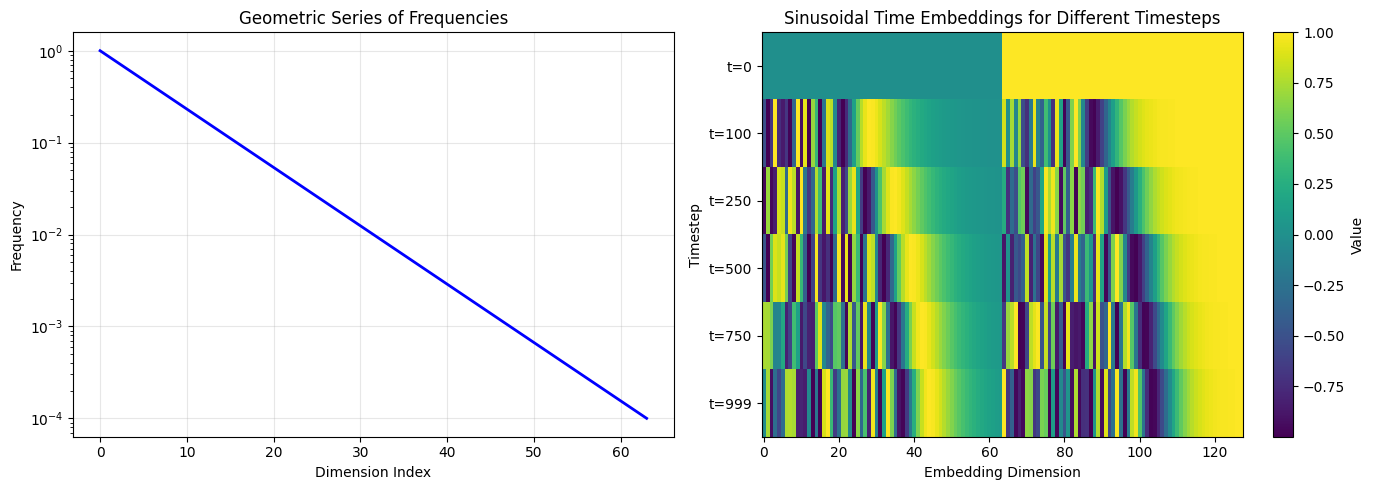

In [83]:
# Visualize geometric series of frequencies used in sinusoidal time embeddings
import math

# Geometric series of frequencies: from 1 to 1/10000
half_dim = 64  # Example embedding dimension / 2
freqs = 10000 ** (-np.arange(half_dim) / (half_dim - 1)) # use half of the frequencies per sin/cos embeding half

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Frequency values across dimensions
axes[0].plot(freqs, 'b-', linewidth=2)
axes[0].set_xlabel('Dimension Index')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Geometric Series of Frequencies')
axes[0].set_yscale('log')
axes[0].grid(True, alpha=0.3)

# Plot 2: Sinusoidal embeddings for different timesteps (heatmap)
timesteps = np.array([0, 100, 250, 500, 750, 999])
emb_matrix = []
for t in timesteps:
    emb = t * freqs
    sin_emb = np.sin(emb)
    cos_emb = np.cos(emb)
    full_emb = np.concatenate([sin_emb, cos_emb])
    emb_matrix.append(full_emb)

emb_matrix = np.array(emb_matrix)
im = axes[1].imshow(emb_matrix, aspect='auto', cmap='viridis')
axes[1].set_xlabel('Embedding Dimension')
axes[1].set_ylabel('Timestep')
axes[1].set_yticks(range(len(timesteps)))
axes[1].set_yticklabels([f't={t}' for t in timesteps])
axes[1].set_title('Sinusoidal Time Embeddings for Different Timesteps')
plt.colorbar(im, ax=axes[1], label='Value')

plt.tight_layout()
plt.show()

In [84]:
class SinusoidalTimeEmbedding(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.emb_dim = emb_dim

    def forward(self, t):
        # TODO 1: Calculate half_dim (we create sin and cos embeddings separately)
        # Hint: Divide emb_dim by 2
        half_dim = self.emb_dim // 2

        # TODO 2: Create geometric freq
        # This creates a geometric series of frequencies for each half of embedding (sin/cos)
        emb_power = torch.arange(half_dim, device=t.device) / (half_dim - 1)
        emb = 10_000.0 ** (-emb_power)
        
        # TODO 3: Multiply timesteps by frequencies (outer product)
        # Hint: t[:, None].float() * emb[None, :]
        # Shape: [batch_size, half_dim]
        emb = t[:, None].float() * emb[None, :]
        
        # TODO 4: Apply sin and cos, then concatenate
        # Hint: torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        # Final shape: [batch_size, emb_dim]
        emb = torch.cat([torch.sin(emb), torch.cos(emb)], dim=-1)
        
        return emb

  <img src="static/arch_residual_block.png" alt="Residual Block Architecture" width="400">

In [85]:
class DDPMResBlock(nn.Module):
    """
    Residual block with time embedding via FiLM conditioning.
    
    Structure: norm -> nonlin -> conv -> time_emb -> norm -> nonlin -> conv -> skip
    With FiLM (Feature-wise Linear Modulation) for time conditioning.
    """
    def __init__(self, in_channels, out_channels, t_emb_dim, nonlinearity=nn.SiLU()):
        super().__init__()
        self.nonlinearity = nonlinearity
        
        # TODO: First conv path:
        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            self.nonlinearity,
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect")
        )
        
        # TODO: Time embedding projection (shift and scale)
        self.time_proj = nn.Sequential(
            self.nonlinearity,
            nn.Linear(t_emb_dim, out_channels * 2)
        )

        # TODO: Second conv path:
        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            self.nonlinearity,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect")
        )
        
        # TODO: Skip connection
        self.residual_conn = nn.Conv2d(in_channels, out_channels, kernel_size=1)
        
        # TODO: Initialize last conv to zero for better training stability w/ nn.init.zeros_
        nn.init.zeros_(self.conv_2[2].weight)
        nn.init.zeros_(self.conv_2[2].bias)

    def forward(self, x, t_emb):
        h = x
        
        # TODO: First block: norm -> nonlin -> conv
        h = self.conv_1(h)
        
        # TODO: Add time embedding (shift and scale)
        t_shift_scale = self.time_proj(t_emb)
        t_shift, t_scale = t_shift_scale.chunk(2, dim=1)
        t_shift = t_shift.unsqueeze(-1).unsqueeze(-1)
        t_scale = t_scale.unsqueeze(-1).unsqueeze(-1)
        h = h * (1 + t_scale) + t_shift
        
        # TODO: Second block: norm -> nonlin -> conv
        h = self.conv_2(h)
        
        # TODO: Return residual connection
        return h + self.residual_conn(x)

 <img src="static/arch_residual_net.png" width="400px">

In [86]:
class ResnetDiffusionModel(nn.Module):
    def __init__(self, K: int = 16, emb_dim: int = 128, data_emb_dim: int = 128, time_steps: int = 1000):
        super().__init__()
        self.K = int(K)
        self.emb_dim = int(emb_dim)
        self.time_steps = int(time_steps)
        self.nonlinearity = nn.SiLU()

        self.time_emb = SinusoidalTimeEmbedding(self.emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(self.emb_dim, self.emb_dim * 4),
            self.nonlinearity,
            nn.Linear(self.emb_dim * 4, self.emb_dim),
        )

        self.data_emb = nn.Embedding(self.K, int(data_emb_dim))

        self.conv_in = nn.Conv2d(int(data_emb_dim), 64, kernel_size=3, padding=1, padding_mode="reflect")

        self.res1 = DDPMResBlock(64, 128, self.emb_dim, self.nonlinearity)
        self.res2 = DDPMResBlock(128, 128, self.emb_dim, self.nonlinearity)
        self.res3 = DDPMResBlock(128, 128, self.emb_dim, self.nonlinearity)
        self.res4 = DDPMResBlock(128, 64, self.emb_dim, self.nonlinearity)

        self.norm_out = nn.GroupNorm(8, 64)
        self.conv_out = nn.Conv2d(64, self.K, kernel_size=1)

    def forward(self, x, t):
        if x.ndim == 2:
            x = x.view(-1, 28, 28)
        elif x.ndim != 3:
            raise ValueError(f"Expected x as [B,S] or [B,28,28], got shape {tuple(x.shape)}")

        x = x.long()
        t_emb = self.time_mlp(self.time_emb(t))

        x_emb = self.data_emb(x)  # [B,28,28,D]
        x_emb = x_emb.permute(0, 3, 1, 2).contiguous()  # [B,D,28,28]

        h = self.conv_in(x_emb)
        h = self.res1(h, t_emb)
        h = self.res2(h, t_emb)
        h = self.res3(h, t_emb)
        h = self.res4(h, t_emb)

        h = self.norm_out(h)
        h = self.nonlinearity(h)
        logits = self.conv_out(h)  # [B,K,28,28]
        return logits.flatten(-2, -1).permute(0, 2, 1)  # [B,S,K]

In [ ]:
# # Train ResnetDiffusionModel

# # Training hyperparameters
# NUM_EPOCHS = 20
# BATCH_SIZE = 64
# LEARNING_RATE = 2e-4
# TIME_STEPS = 200

# # Setup optimizer
# model = ResnetDiffusionModel().to(device)
# train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
# test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# train(
#     model,
#     train_loader,
#     test_loader,
#     NUM_EPOCHS,
#     LEARNING_RATE,
#     TIME_STEPS,
#     schedule_fn=cosine_schedule,
#     transition_kernel_fn=absorbing_kernel,
#     device=device,
#     recon_t_noise=125,
# )


### 4.3 U-Net + Attention

<img src="static/arch_residual_attn_block.png" width="350">

In [88]:
class DDPMResAttnBlock(nn.Module):
    def __init__(self, in_channels, out_channels, t_emb_dim, num_heads=4, use_attn=True):
        super().__init__()
        self.use_attn = use_attn
        self.nonlinearity = nn.SiLU()

        self.conv_1 = nn.Sequential(
            nn.GroupNorm(8, in_channels),
            self.nonlinearity,
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        self.time_proj = nn.Sequential(
            self.nonlinearity,
            nn.Linear(t_emb_dim, out_channels * 2),
        )

        self.conv_2 = nn.Sequential(
            nn.GroupNorm(8, out_channels),
            self.nonlinearity,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, padding_mode="reflect"),
        )

        self.skip_conn = nn.Conv2d(in_channels, out_channels, kernel_size=1)

        if self.use_attn:
            self.attn_norm = nn.GroupNorm(8, out_channels)
            self.mha = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

        nn.init.zeros_(self.conv_2[2].weight)
        nn.init.zeros_(self.conv_2[2].bias)

    def forward(self, x, t_emb):
        h = self.conv_1(x)

        t_emb = self.time_proj(t_emb)
        scale, shift = t_emb.chunk(2, dim=1)
        scale = scale.unsqueeze(-1).unsqueeze(-1)
        shift = shift.unsqueeze(-1).unsqueeze(-1)
        h = (1 + scale) * h + shift

        h = self.conv_2(h)
        h = h + self.skip_conn(x)

        if self.use_attn:
            B, C, H, W = h.shape
            a = self.attn_norm(h).flatten(2).transpose(1, 2)  # [B,HW,C]
            a, _ = self.mha(a, a, a)
            a = a.transpose(1, 2).reshape(B, C, H, W)
            h = h + a

        return h

<img src="static/arch_unet.png" width="500">

In [89]:
class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels,
            kernel_size=3, stride=2, padding=1, padding_mode="reflect"
        )

    def forward(self, x):
        return self.conv(x)


class Upsample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.up = nn.Upsample(scale_factor=2, mode="nearest")
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        return self.conv(self.up(x))

In [90]:
class UnetDiffusionModel(nn.Module):
    def __init__(
        self,
        K: int = 16,
        emb_dim=128,
        time_steps=1000,
        dropout=0.1,
        num_heads=4,
        use_attention=False,
    ):
        super().__init__()
        self.K = int(K)
        self.emb_dim = emb_dim
        self.time_steps = time_steps
        self.nonlinearity = nn.SiLU()

        self.time_emb = SinusoidalTimeEmbedding(emb_dim)
        self.time_mlp = nn.Sequential(
            nn.Linear(emb_dim, emb_dim * 4),
            self.nonlinearity,
            nn.Linear(emb_dim * 4, emb_dim),
        )

        self.data_emb = nn.Embedding(self.K, self.emb_dim)
        self.conv_in = nn.Conv2d(self.emb_dim, 32, kernel_size=3, padding=1, padding_mode="reflect")

        self.enc1 = DDPMResAttnBlock(32, 32, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.down1 = Downsample(32, 32)

        self.enc2 = DDPMResAttnBlock(32, 64, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.down2 = Downsample(64, 64)

        self.mid = DDPMResAttnBlock(64, 128, emb_dim, num_heads=num_heads, use_attn=use_attention)

        self.dec3 = DDPMResAttnBlock(64 + 64, 64, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.up3 = Upsample(128, 64)

        self.dec2 = DDPMResAttnBlock(32 + 32, 32, emb_dim, num_heads=num_heads, use_attn=use_attention)
        self.up2 = Upsample(64, 32)

        self.norm_out = nn.GroupNorm(8, 32)
        self.conv_out = nn.Conv2d(32, self.K, kernel_size=1)

    def forward(self, x, t):
        if x.ndim == 2:
            x = x.view(-1, 28, 28)
        elif x.ndim != 3:
            raise ValueError(f"Expected x as [B,S] or [B,28,28], got shape {tuple(x.shape)}")

        x = x.long()
        t_emb = self.time_mlp(self.time_emb(t))

        x_emb = self.data_emb(x).permute(0, 3, 1, 2).contiguous()  # [B,D,28,28]
        h = self.conv_in(x_emb)

        e1 = self.enc1(h, t_emb)
        h = self.down1(e1)

        e2 = self.enc2(h, t_emb)
        h = self.down2(e2)

        h = self.mid(h, t_emb)

        h = self.up3(h)
        h = torch.cat([h, e2], dim=1)
        h = self.dec3(h, t_emb)

        h = self.up2(h)
        h = torch.cat([h, e1], dim=1)
        h = self.dec2(h, t_emb)

        h = self.norm_out(h)
        h = self.nonlinearity(h)
        logits = self.conv_out(h)  # [B,K,28,28]
        return logits.flatten(-2, -1).permute(0, 2, 1)  # [B,S,K]

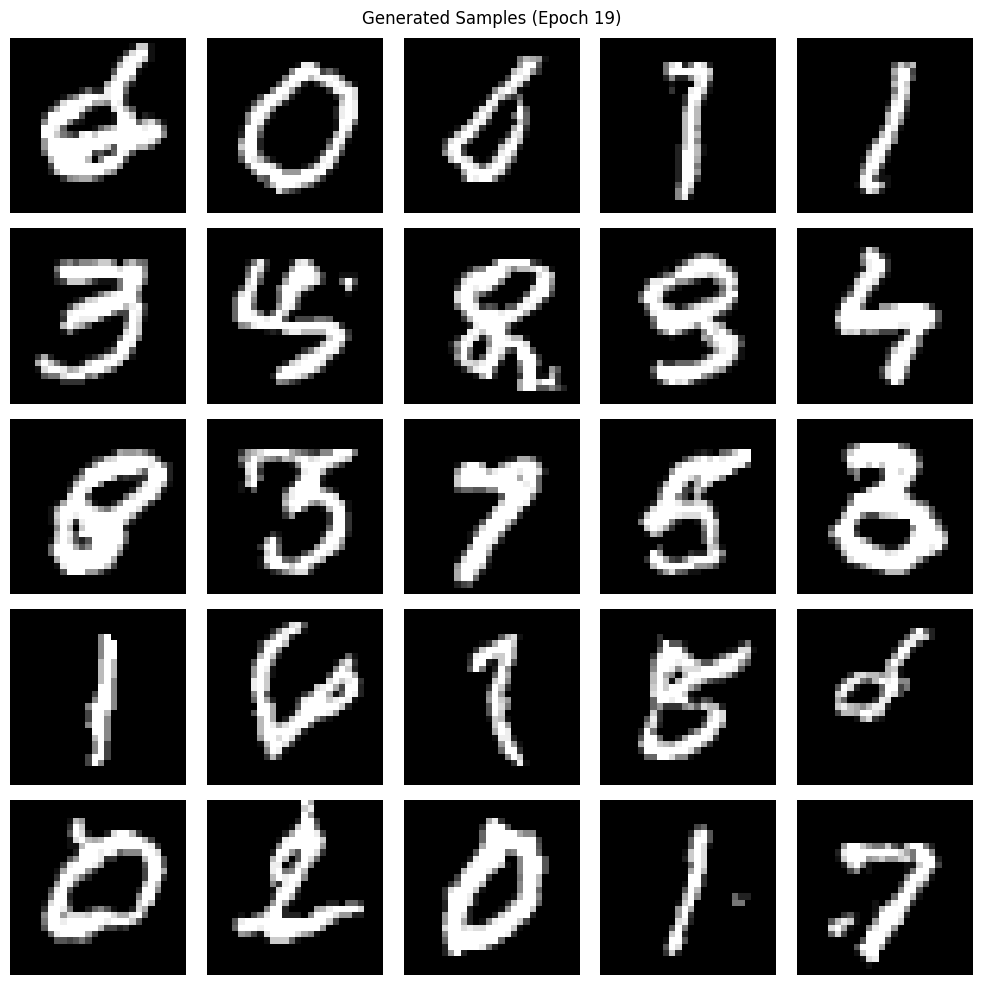

Visualizing: 100%|██████████| 5/5 [00:00<00:00, 470.87it/s]


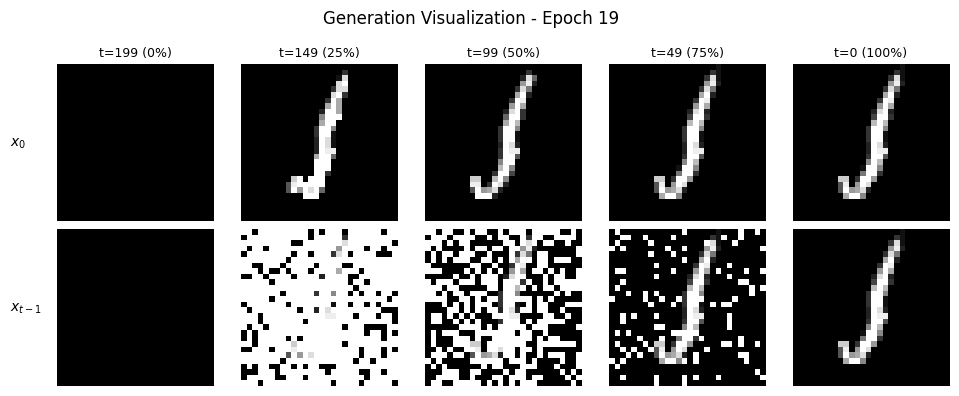

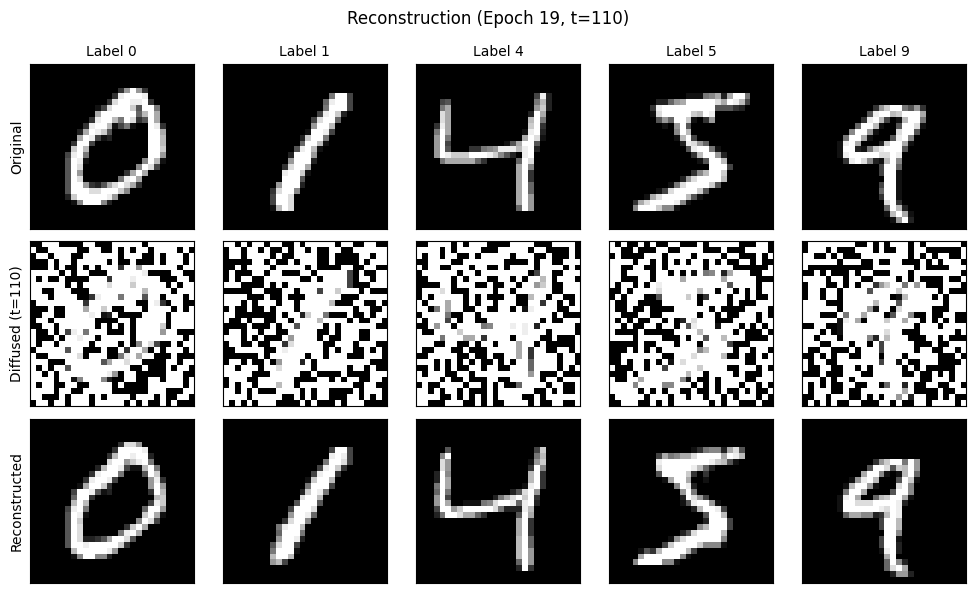

Epochs: 100%|██████████| 20/20 [20:14<00:00, 60.73s/it]

Model: UnetDiffusionModel | Params: 849,136 (trainable: 849,136)
Epoch 19/19 completed. Train Loss: 0.2130 | Test Loss: 0.2693 | Train Time: 56.54s


In [95]:
# Train Unet

# Training hyperparameters
NUM_EPOCHS = 20
BATCH_SIZE = 64
LEARNING_RATE = 2e-4
TIME_STEPS = 200

# Setup optimizer
model = UnetDiffusionModel(K=quantized_train_dataset_absorbing.K).to(device)
train_loader = DataLoader(quantized_train_dataset_absorbing, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
test_loader = DataLoader(quantized_test_dataset_absorbing, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

train(
    model,
    train_loader,
    test_loader,
    NUM_EPOCHS,
    LEARNING_RATE,
    TIME_STEPS,
    schedule_fn=cosine_schedule,
    transition_kernel_fn=absorbing_kernel,
    device=device,
    recon_t_noise=110,
)


In [ ]:
# Generate GIFs to view the training progress

from pathlib import Path
from PIL import Image

root = Path("data/experiments/MNIST")
assert root.exists(), f"Missing: {root.resolve()}"

viz_subdirs = ["viz/gen_samples", "viz/gen_timeline", "viz/recon_samples"]

def epoch_key(p: Path) -> int:
    try:
        return int(p.stem)
    except ValueError:
        return 10**18

def make_gif(frames: list[Path], out_path: Path, fps: int = 6, loop: int = 0) -> Path:
    imgs = [Image.open(p).convert("RGBA") for p in frames]
    try:
        out_path.parent.mkdir(parents=True, exist_ok=True)
        imgs[0].save(
            out_path,
            save_all=True,
            append_images=imgs[1:],
            duration=int(1000 / fps),
            loop=loop,
            optimize=False,
        )
        return out_path.resolve()
    finally:
        for im in imgs:
            im.close()

for model_dir in sorted(p for p in root.iterdir() if p.is_dir()):
    print(f"\n=== {model_dir.name} ===")
    for rel in viz_subdirs:
        d = model_dir / rel
        out_gif = d / f"{d.name}.gif"
        frames = sorted(d.glob("*.png"), key=epoch_key) if d.exists() else []
        if len(frames) >= 2:
            out = make_gif(frames, out_gif, fps=6)
            print(out)
        else:
            print(out_gif.resolve())


=== ResnetDiffusionModel ===
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/ResnetDiffusionModel/viz/gen_samples/gen_samples.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/ResnetDiffusionModel/viz/gen_timeline/gen_timeline.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/ResnetDiffusionModel/viz/recon_samples/recon_samples.gif

=== SimpleCNNDiffusionModel ===
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/SimpleCNNDiffusionModel/viz/gen_samples/gen_samples.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/SimpleCNNDiffusionModel/viz/gen_timeline/gen_timeline.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/SimpleCNNDiffusionModel/viz/recon_samples/recon_samples.gif

=== UnetDiffusionModel ===
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/UnetDiffusionModel/viz/gen_samples/gen_samples.gif
/Users/a1111/deep-learning-course-2026/data/experiments/MNIST/UnetDiffusionModel/viz/

## Auxilary visualizations

/tmp/ipython-input-4259352364.py:14: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  noisy_image = np.sqrt(1 - beta) * sample_image + np.sqrt(beta) * noise


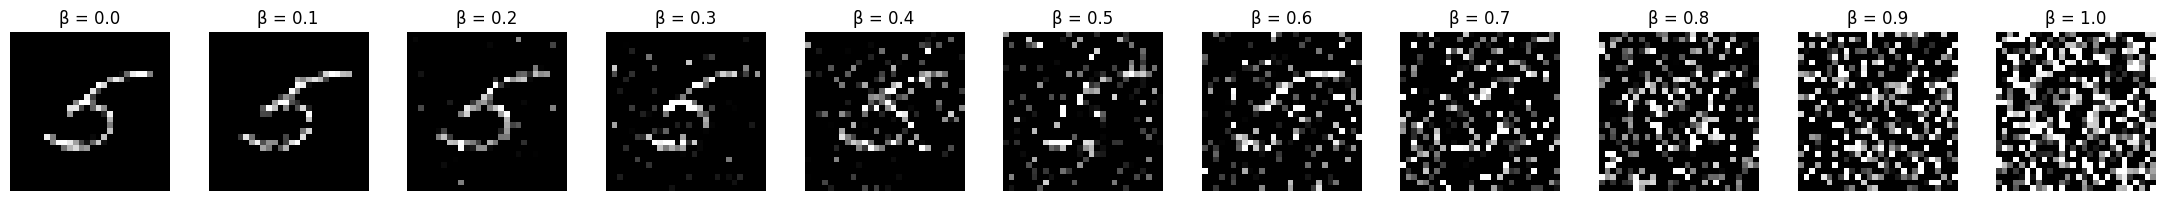

In [ ]:
# Visualize the effect of different beta values on a sample image
import matplotlib.pyplot as plt
import numpy as np

# Define different beta values to test
beta_values = np.arange(0.0, 1.1, 0.1)

# Create a figure to show the effect of different betas
fig, axes = plt.subplots(1, 11, figsize=(22, 2))

for idx, beta in enumerate(beta_values):
    # Apply forward diffusion with the given beta
    noise = np.random.randn(*sample_image.shape)
    noisy_image = np.sqrt(1 - beta) * sample_image + np.sqrt(beta) * noise
    
    # Clip values to valid range
    noisy_image = np.clip(noisy_image, 0, 1)
    
    # Display the noisy image
    axes[idx].imshow(noisy_image.squeeze(), cmap='gray')
    axes[idx].set_title(f'β = {beta:.1f}')
    axes[idx].axis('off')

# plt.suptitle('Effect of Different Beta Values on Forward Diffusion', fontsize=14)
plt.tight_layout()
plt.show()


/tmp/ipython-input-2701695812.py:16: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_t = np.sqrt(1 - beta_t) * sample_image + np.sqrt(beta_t) * noise_t
/tmp/ipython-input-2701695812.py:63: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_t_minus_1 = np.sqrt(1 - beta_t_minus_1) * source_image + np.sqrt(beta_t_minus_1) * epsilon


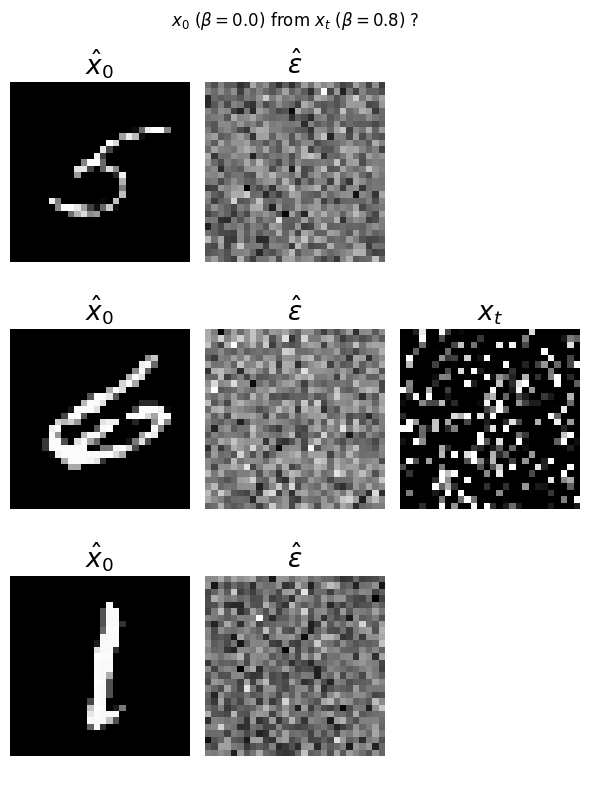

In [ ]:
# Generate k=5 random noises and reverse diffusion step
import numpy as np

k = 3
beta_t = 0.8  # Current noise level
UNIQUE_SOURCES_TRUE = True  # When True, show random unique images as candidates (with true sample among them)
RESTORE_INITIAL_TRUE = True  # When True, restore initial image (beta_t_minus_1 = 0)

beta_t_minus_1 = 0.0 if RESTORE_INITIAL_TRUE else 0.4  # Previous noise level

# Fix seed for reproducibility when sampling unique sources
rng = np.random.RandomState(42)

# Create the current noisy image at beta_t
noise_t = rng.randn(*sample_image.shape)
x_t = np.sqrt(1 - beta_t) * sample_image + np.sqrt(beta_t) * noise_t
x_t = np.clip(x_t, 0, 1)

# Generate k random noises and compute possible previous states
# Columns: img_diffused_t-1, noise_t-1, img_diffused_t
fig, axes = plt.subplots(k, 3, figsize=(6, 8))

# Randomly select which row gets the "true" answer (the actual sample_image diffused)
true_row = rng.randint(0, k) if UNIQUE_SOURCES_TRUE else -1

# Get random unique images from the dataset with different labels if UNIQUE_SOURCES_TRUE
if UNIQUE_SOURCES_TRUE:
    # Collect images with different labels
    used_labels = set()
    random_images = []
    random_labels = []
    
    # Shuffle indices to get random order (using fixed seed)
    all_indices = rng.permutation(len(train_dataset))
    
    for idx in all_indices:
        img, label = train_dataset[idx]
        if label not in used_labels:
            used_labels.add(label)
            random_images.append(img.numpy().squeeze())
            random_labels.append(label)
        if len(random_images) >= k - 1:
            break

for i in range(k):
    # Generate random noise for this sample
    epsilon = rng.randn(*sample_image.shape)
    
    # Determine which source image to use
    if UNIQUE_SOURCES_TRUE:
        if i == true_row:
            # Use the actual sample_image for the true row
            source_image = sample_image
        else:
            # Use a random unique image with different label
            # Adjust index to account for the true_row position
            random_idx = i if i < true_row else i - 1
            source_image = random_images[random_idx]
    else:
        source_image = sample_image
    
    # Compute x_{t-1} from the source image with beta_t_minus_1
    x_t_minus_1 = np.sqrt(1 - beta_t_minus_1) * source_image + np.sqrt(beta_t_minus_1) * epsilon
    x_t_minus_1 = np.clip(x_t_minus_1, 0, 1)
    
    # Column 0: x_{t-1} samples (or x_0 if restoring initial)
    axes[i, 0].imshow(x_t_minus_1.squeeze(), cmap='gray')
    x_label = '$\\hat{x}_0$' if RESTORE_INITIAL_TRUE else '$\\hat{x}_{t-1}$'
    axes[i, 0].set_title(x_label, fontsize=19)
    axes[i, 0].axis('off')
    
    # Column 1: noise used for this sample
    axes[i, 1].imshow(epsilon.squeeze(), cmap='gray')
    epsilon_label = '$\\hat{\\epsilon}$' if RESTORE_INITIAL_TRUE else '$\\hat{\\epsilon}_{t}$'
    axes[i, 1].set_title(epsilon_label, fontsize=19)
    axes[i, 1].axis('off')
    
    # Column 2: show x_t only in the middle row
    middle_row = k // 2
    if i == middle_row:
        axes[i, 2].imshow(x_t.squeeze(), cmap='gray')
        axes[i, 2].set_title(f'$x_t$', fontsize=19)
        axes[i, 2].axis('off')
    else:
        axes[i, 2].axis('off')

x_prev_label = '$x_0$' if RESTORE_INITIAL_TRUE else '$x_{t-1}$'
plt.suptitle(f'{x_prev_label} ($\\beta={beta_t_minus_1}$) from $x_t$ ($\\beta={beta_t}$) ?', fontsize=12)
plt.tight_layout()
plt.show()